In [1]:
from typing import Tuple, Optional, Union
import math
import torch as th
import torch
import torch.nn as nn
import torchaudio as ta
from torchaudio.transforms import PSD
import torch.nn.functional as F

from Modules import STFT, MVDR
from model import Unet_model
from data import my_dataset
from matplotlib import pyplot as plt
from loss import MultiResSpecLoss

In [2]:
data_train = my_dataset('./beam_data/train')

model_mask = Unet_model(subband_flag=True)
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [3]:
train_target, train_sample, train_noise = data_train[0]

In [4]:
crit = MultiResSpecLoss(factor=100,
            f_complex=100,
            gamma=0.3,
            n_ffts=[1024, window_length])

In [5]:
from tqdm import tqdm
from torchmetrics import ScaleInvariantSignalNoiseRatio

epochs = 1000

optim = torch.optim.AdamW(model_mask.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=40
        )

si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
#     mvdr = MVDR(0)
    spec_sample = stft.stft(train_sample[None])
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

    mask = model_mask(spec_sample)
#     z = mvdr(spec_sample, mask[0])
    mag_predict = mag * mask

    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = crit(wave_predict, train_target[None]) + F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    
    metrics.append(si(wave_predict.detach(), train_target[None]))
    losses.append(loss.item())
    print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

  0%|                                                                                 | 1/1000 [00:00<15:49,  1.05it/s]

Epoch [1/1000], loss: 7.1286, metric: -32.9324


  0%|▏                                                                                | 2/1000 [00:01<09:23,  1.77it/s]

Epoch [2/1000], loss: 7.0904, metric: -36.3529


  0%|▏                                                                                | 3/1000 [00:01<07:11,  2.31it/s]

Epoch [3/1000], loss: 7.0537, metric: -42.3489


  0%|▎                                                                                | 4/1000 [00:01<06:16,  2.65it/s]

Epoch [4/1000], loss: 7.0164, metric: -63.4843


  0%|▍                                                                                | 5/1000 [00:02<05:39,  2.93it/s]

Epoch [5/1000], loss: 6.9808, metric: -41.2905


  1%|▍                                                                                | 6/1000 [00:02<05:18,  3.12it/s]

Epoch [6/1000], loss: 6.9452, metric: -35.7524


  1%|▌                                                                                | 7/1000 [00:02<05:13,  3.17it/s]

Epoch [7/1000], loss: 6.9088, metric: -32.3287


  1%|▋                                                                                | 8/1000 [00:02<05:02,  3.28it/s]

Epoch [8/1000], loss: 6.8723, metric: -29.8223


  1%|▋                                                                                | 9/1000 [00:03<04:58,  3.32it/s]

Epoch [9/1000], loss: 6.8355, metric: -27.8292


  1%|▊                                                                               | 10/1000 [00:03<04:59,  3.30it/s]

Epoch [10/1000], loss: 6.7978, metric: -26.1715


  1%|▉                                                                               | 11/1000 [00:03<04:58,  3.32it/s]

Epoch [11/1000], loss: 6.7600, metric: -24.7771


  1%|▉                                                                               | 12/1000 [00:04<04:55,  3.34it/s]

Epoch [12/1000], loss: 6.7229, metric: -23.5987


  1%|█                                                                               | 13/1000 [00:04<04:57,  3.31it/s]

Epoch [13/1000], loss: 6.6858, metric: -22.5907


  1%|█                                                                               | 14/1000 [00:04<04:57,  3.31it/s]

Epoch [14/1000], loss: 6.6480, metric: -21.7087


  2%|█▏                                                                              | 15/1000 [00:05<05:00,  3.28it/s]

Epoch [15/1000], loss: 6.6091, metric: -20.9232


  2%|█▎                                                                              | 16/1000 [00:05<04:54,  3.35it/s]

Epoch [16/1000], loss: 6.5689, metric: -20.2103


  2%|█▎                                                                              | 17/1000 [00:05<04:56,  3.32it/s]

Epoch [17/1000], loss: 6.5271, metric: -19.5580


  2%|█▍                                                                              | 18/1000 [00:05<04:57,  3.30it/s]

Epoch [18/1000], loss: 6.4835, metric: -18.9383


  2%|█▌                                                                              | 19/1000 [00:06<05:00,  3.27it/s]

Epoch [19/1000], loss: 6.4383, metric: -18.3396


  2%|█▌                                                                              | 20/1000 [00:06<05:00,  3.26it/s]

Epoch [20/1000], loss: 6.3919, metric: -17.7702


  2%|█▋                                                                              | 21/1000 [00:06<04:58,  3.28it/s]

Epoch [21/1000], loss: 6.3451, metric: -17.2502


  2%|█▊                                                                              | 22/1000 [00:07<04:53,  3.33it/s]

Epoch [22/1000], loss: 6.2984, metric: -16.7749


  2%|█▊                                                                              | 23/1000 [00:07<04:54,  3.31it/s]

Epoch [23/1000], loss: 6.2523, metric: -16.3313


  2%|█▉                                                                              | 24/1000 [00:07<04:50,  3.36it/s]

Epoch [24/1000], loss: 6.2066, metric: -15.9106


  2%|██                                                                              | 25/1000 [00:08<04:48,  3.38it/s]

Epoch [25/1000], loss: 6.1618, metric: -15.5158


  3%|██                                                                              | 26/1000 [00:08<04:42,  3.45it/s]

Epoch [26/1000], loss: 6.1181, metric: -15.1529


  3%|██▏                                                                             | 27/1000 [00:08<04:37,  3.51it/s]

Epoch [27/1000], loss: 6.0752, metric: -14.8114


  3%|██▏                                                                             | 28/1000 [00:08<04:33,  3.56it/s]

Epoch [28/1000], loss: 6.0326, metric: -14.4869


  3%|██▎                                                                             | 29/1000 [00:09<04:32,  3.56it/s]

Epoch [29/1000], loss: 5.9900, metric: -14.1520


  3%|██▍                                                                             | 30/1000 [00:09<04:29,  3.60it/s]

Epoch [30/1000], loss: 5.9471, metric: -13.7896


  3%|██▍                                                                             | 31/1000 [00:09<04:27,  3.62it/s]

Epoch [31/1000], loss: 5.9037, metric: -13.3790


  3%|██▌                                                                             | 32/1000 [00:09<04:25,  3.64it/s]

Epoch [32/1000], loss: 5.8599, metric: -12.9249


  3%|██▋                                                                             | 33/1000 [00:10<04:24,  3.66it/s]

Epoch [33/1000], loss: 5.8153, metric: -12.4149


  3%|██▋                                                                             | 34/1000 [00:10<04:22,  3.68it/s]

Epoch [34/1000], loss: 5.7696, metric: -11.7998


  4%|██▊                                                                             | 35/1000 [00:10<04:21,  3.68it/s]

Epoch [35/1000], loss: 5.7237, metric: -11.2247


  4%|██▉                                                                             | 36/1000 [00:11<04:23,  3.67it/s]

Epoch [36/1000], loss: 5.6803, metric: -10.7826


  4%|██▉                                                                             | 37/1000 [00:11<04:22,  3.67it/s]

Epoch [37/1000], loss: 5.6417, metric: -10.3001


  4%|███                                                                             | 38/1000 [00:11<04:28,  3.59it/s]

Epoch [38/1000], loss: 5.6155, metric: -10.3180


  4%|███                                                                             | 39/1000 [00:11<04:30,  3.55it/s]

Epoch [39/1000], loss: 5.5837, metric: -9.6603


  4%|███▏                                                                            | 40/1000 [00:12<04:32,  3.52it/s]

Epoch [40/1000], loss: 5.5415, metric: -9.5012


  4%|███▎                                                                            | 41/1000 [00:12<04:28,  3.58it/s]

Epoch [41/1000], loss: 5.5113, metric: -9.2437


  4%|███▎                                                                            | 42/1000 [00:12<04:26,  3.60it/s]

Epoch [42/1000], loss: 5.4857, metric: -8.8340


  4%|███▍                                                                            | 43/1000 [00:13<04:28,  3.56it/s]

Epoch [43/1000], loss: 5.4486, metric: -8.6655


  4%|███▌                                                                            | 44/1000 [00:13<04:25,  3.60it/s]

Epoch [44/1000], loss: 5.4256, metric: -8.5850


  4%|███▌                                                                            | 45/1000 [00:13<04:21,  3.65it/s]

Epoch [45/1000], loss: 5.3952, metric: -8.2215


  5%|███▋                                                                            | 46/1000 [00:13<04:26,  3.58it/s]

Epoch [46/1000], loss: 5.3689, metric: -8.0502


  5%|███▊                                                                            | 47/1000 [00:14<04:26,  3.57it/s]

Epoch [47/1000], loss: 5.3448, metric: -8.0175


  5%|███▊                                                                            | 48/1000 [00:14<04:24,  3.60it/s]

Epoch [48/1000], loss: 5.3175, metric: -7.8077


  5%|███▉                                                                            | 49/1000 [00:14<04:20,  3.65it/s]

Epoch [49/1000], loss: 5.2954, metric: -7.6002


  5%|████                                                                            | 50/1000 [00:14<04:18,  3.67it/s]

Epoch [50/1000], loss: 5.2690, metric: -7.5048


  5%|████                                                                            | 51/1000 [00:15<04:21,  3.63it/s]

Epoch [51/1000], loss: 5.2481, metric: -7.4567


  5%|████▏                                                                           | 52/1000 [00:15<04:21,  3.63it/s]

Epoch [52/1000], loss: 5.2234, metric: -7.2497


  5%|████▏                                                                           | 53/1000 [00:15<04:21,  3.62it/s]

Epoch [53/1000], loss: 5.2021, metric: -7.1280


  5%|████▎                                                                           | 54/1000 [00:16<04:21,  3.61it/s]

Epoch [54/1000], loss: 5.1798, metric: -7.0992


  6%|████▍                                                                           | 55/1000 [00:16<04:19,  3.64it/s]

Epoch [55/1000], loss: 5.1579, metric: -6.9899


  6%|████▍                                                                           | 56/1000 [00:16<04:19,  3.64it/s]

Epoch [56/1000], loss: 5.1371, metric: -6.8498


  6%|████▌                                                                           | 57/1000 [00:16<04:20,  3.61it/s]

Epoch [57/1000], loss: 5.1147, metric: -6.8007


  6%|████▋                                                                           | 58/1000 [00:17<04:20,  3.61it/s]

Epoch [58/1000], loss: 5.0943, metric: -6.7459


  6%|████▋                                                                           | 59/1000 [00:17<04:26,  3.53it/s]

Epoch [59/1000], loss: 5.0736, metric: -6.6161


  6%|████▊                                                                           | 60/1000 [00:17<04:21,  3.59it/s]

Epoch [60/1000], loss: 5.0529, metric: -6.5519


  6%|████▉                                                                           | 61/1000 [00:18<04:28,  3.50it/s]

Epoch [61/1000], loss: 5.0328, metric: -6.4978


  6%|████▉                                                                           | 62/1000 [00:18<04:29,  3.47it/s]

Epoch [62/1000], loss: 5.0123, metric: -6.3859


  6%|█████                                                                           | 63/1000 [00:18<04:34,  3.41it/s]

Epoch [63/1000], loss: 4.9923, metric: -6.3082


  6%|█████                                                                           | 64/1000 [00:18<04:34,  3.41it/s]

Epoch [64/1000], loss: 4.9731, metric: -6.2573


  6%|█████▏                                                                          | 65/1000 [00:19<04:33,  3.41it/s]

Epoch [65/1000], loss: 4.9549, metric: -6.1492


  7%|█████▎                                                                          | 66/1000 [00:19<04:36,  3.37it/s]

Epoch [66/1000], loss: 4.9364, metric: -6.1131


  7%|█████▎                                                                          | 67/1000 [00:19<04:36,  3.37it/s]

Epoch [67/1000], loss: 4.9178, metric: -6.0543


  7%|█████▍                                                                          | 68/1000 [00:20<04:39,  3.33it/s]

Epoch [68/1000], loss: 4.8993, metric: -5.9881


  7%|█████▌                                                                          | 69/1000 [00:20<04:42,  3.29it/s]

Epoch [69/1000], loss: 4.8808, metric: -5.9498


  7%|█████▌                                                                          | 70/1000 [00:20<04:42,  3.29it/s]

Epoch [70/1000], loss: 4.8624, metric: -5.8565


  7%|█████▋                                                                          | 71/1000 [00:21<04:43,  3.28it/s]

Epoch [71/1000], loss: 4.8443, metric: -5.7949


  7%|█████▊                                                                          | 72/1000 [00:21<04:44,  3.26it/s]

Epoch [72/1000], loss: 4.8269, metric: -5.7539


  7%|█████▊                                                                          | 73/1000 [00:21<04:36,  3.35it/s]

Epoch [73/1000], loss: 4.8096, metric: -5.6532


  7%|█████▉                                                                          | 74/1000 [00:21<04:28,  3.45it/s]

Epoch [74/1000], loss: 4.7917, metric: -5.6489


  8%|██████                                                                          | 75/1000 [00:22<04:24,  3.50it/s]

Epoch [75/1000], loss: 4.7744, metric: -5.5572


  8%|██████                                                                          | 76/1000 [00:22<04:21,  3.54it/s]

Epoch [76/1000], loss: 4.7587, metric: -5.5089


  8%|██████▏                                                                         | 77/1000 [00:22<04:17,  3.58it/s]

Epoch [77/1000], loss: 4.7430, metric: -5.5173


  8%|██████▏                                                                         | 78/1000 [00:23<04:19,  3.55it/s]

Epoch [78/1000], loss: 4.7267, metric: -5.4289


  8%|██████▎                                                                         | 79/1000 [00:23<04:26,  3.46it/s]

Epoch [79/1000], loss: 4.7148, metric: -5.4427


  8%|██████▍                                                                         | 80/1000 [00:23<04:24,  3.47it/s]

Epoch [80/1000], loss: 4.7023, metric: -5.3732


  8%|██████▍                                                                         | 81/1000 [00:23<04:25,  3.45it/s]

Epoch [81/1000], loss: 4.6881, metric: -5.3109


  8%|██████▌                                                                         | 82/1000 [00:24<04:33,  3.36it/s]

Epoch [82/1000], loss: 4.6735, metric: -5.3088


  8%|██████▋                                                                         | 83/1000 [00:24<04:35,  3.33it/s]

Epoch [83/1000], loss: 4.6565, metric: -5.2141


  8%|██████▋                                                                         | 84/1000 [00:24<04:38,  3.29it/s]

Epoch [84/1000], loss: 4.6396, metric: -5.1957


  8%|██████▊                                                                         | 85/1000 [00:25<04:30,  3.38it/s]

Epoch [85/1000], loss: 4.6234, metric: -5.1394


  9%|██████▉                                                                         | 86/1000 [00:25<04:39,  3.27it/s]

Epoch [86/1000], loss: 4.6076, metric: -5.0983


  9%|██████▉                                                                         | 87/1000 [00:25<04:46,  3.19it/s]

Epoch [87/1000], loss: 4.5922, metric: -5.0640


  9%|███████                                                                         | 88/1000 [00:26<04:45,  3.19it/s]

Epoch [88/1000], loss: 4.5770, metric: -5.0048


  9%|███████                                                                         | 89/1000 [00:26<04:44,  3.20it/s]

Epoch [89/1000], loss: 4.5617, metric: -4.9900


  9%|███████▏                                                                        | 90/1000 [00:26<04:43,  3.21it/s]

Epoch [90/1000], loss: 4.5466, metric: -4.9264


  9%|███████▎                                                                        | 91/1000 [00:27<04:42,  3.22it/s]

Epoch [91/1000], loss: 4.5318, metric: -4.9169


  9%|███████▎                                                                        | 92/1000 [00:27<04:46,  3.17it/s]

Epoch [92/1000], loss: 4.5172, metric: -4.8498


  9%|███████▍                                                                        | 93/1000 [00:27<04:37,  3.27it/s]

Epoch [93/1000], loss: 4.5027, metric: -4.8403


  9%|███████▌                                                                        | 94/1000 [00:27<04:33,  3.32it/s]

Epoch [94/1000], loss: 4.4884, metric: -4.7722


 10%|███████▌                                                                        | 95/1000 [00:28<04:31,  3.33it/s]

Epoch [95/1000], loss: 4.4742, metric: -4.7737


 10%|███████▋                                                                        | 96/1000 [00:28<04:33,  3.31it/s]

Epoch [96/1000], loss: 4.4606, metric: -4.7001


 10%|███████▊                                                                        | 97/1000 [00:28<04:35,  3.28it/s]

Epoch [97/1000], loss: 4.4478, metric: -4.7248


 10%|███████▊                                                                        | 98/1000 [00:29<04:37,  3.25it/s]

Epoch [98/1000], loss: 4.4352, metric: -4.6297


 10%|███████▉                                                                        | 99/1000 [00:29<04:29,  3.35it/s]

Epoch [99/1000], loss: 4.4218, metric: -4.6680


 10%|███████▉                                                                       | 100/1000 [00:29<04:33,  3.29it/s]

Epoch [100/1000], loss: 4.4077, metric: -4.5689


 10%|███████▉                                                                       | 101/1000 [00:30<04:36,  3.25it/s]

Epoch [101/1000], loss: 4.3929, metric: -4.5733


 10%|████████                                                                       | 102/1000 [00:30<04:25,  3.38it/s]

Epoch [102/1000], loss: 4.3796, metric: -4.5394


 10%|████████▏                                                                      | 103/1000 [00:30<04:17,  3.48it/s]

Epoch [103/1000], loss: 4.3679, metric: -4.4879


 10%|████████▏                                                                      | 104/1000 [00:30<04:13,  3.54it/s]

Epoch [104/1000], loss: 4.3572, metric: -4.5284


 10%|████████▎                                                                      | 105/1000 [00:31<04:08,  3.59it/s]

Epoch [105/1000], loss: 4.3441, metric: -4.4274


 11%|████████▎                                                                      | 106/1000 [00:31<04:19,  3.45it/s]

Epoch [106/1000], loss: 4.3296, metric: -4.4045


 11%|████████▍                                                                      | 107/1000 [00:31<04:28,  3.33it/s]

Epoch [107/1000], loss: 4.3189, metric: -4.4091


 11%|████████▌                                                                      | 108/1000 [00:32<04:19,  3.44it/s]

Epoch [108/1000], loss: 4.3094, metric: -4.3342


 11%|████████▌                                                                      | 109/1000 [00:32<04:31,  3.28it/s]

Epoch [109/1000], loss: 4.2944, metric: -4.3527


 11%|████████▋                                                                      | 110/1000 [00:32<04:21,  3.41it/s]

Epoch [110/1000], loss: 4.2823, metric: -4.3269


 11%|████████▊                                                                      | 111/1000 [00:32<04:15,  3.48it/s]

Epoch [111/1000], loss: 4.2738, metric: -4.2603


 11%|████████▊                                                                      | 112/1000 [00:33<04:22,  3.39it/s]

Epoch [112/1000], loss: 4.2618, metric: -4.2486


 11%|████████▉                                                                      | 113/1000 [00:33<04:25,  3.34it/s]

Epoch [113/1000], loss: 4.2541, metric: -4.2564


 11%|█████████                                                                      | 114/1000 [00:33<04:24,  3.35it/s]

Epoch [114/1000], loss: 4.2465, metric: -4.2091


 12%|█████████                                                                      | 115/1000 [00:34<04:34,  3.22it/s]

Epoch [115/1000], loss: 4.2324, metric: -4.2255


 12%|█████████▏                                                                     | 116/1000 [00:34<04:40,  3.15it/s]

Epoch [116/1000], loss: 4.2232, metric: -4.2149


 12%|█████████▏                                                                     | 117/1000 [00:34<04:31,  3.25it/s]

Epoch [117/1000], loss: 4.2143, metric: -4.1287


 12%|█████████▎                                                                     | 118/1000 [00:35<04:30,  3.26it/s]

Epoch [118/1000], loss: 4.1997, metric: -4.1041


 12%|█████████▍                                                                     | 119/1000 [00:35<04:37,  3.17it/s]

Epoch [119/1000], loss: 4.1906, metric: -4.1112


 12%|█████████▍                                                                     | 120/1000 [00:35<04:57,  2.96it/s]

Epoch [120/1000], loss: 4.1794, metric: -4.0563


 12%|█████████▌                                                                     | 121/1000 [00:36<04:53,  2.99it/s]

Epoch [121/1000], loss: 4.1678, metric: -4.0511


 12%|█████████▋                                                                     | 122/1000 [00:36<04:40,  3.13it/s]

Epoch [122/1000], loss: 4.1585, metric: -4.0615


 12%|█████████▋                                                                     | 123/1000 [00:36<04:27,  3.28it/s]

Epoch [123/1000], loss: 4.1469, metric: -3.9943


 12%|█████████▊                                                                     | 124/1000 [00:36<04:17,  3.40it/s]

Epoch [124/1000], loss: 4.1372, metric: -3.9588


 12%|█████████▉                                                                     | 125/1000 [00:37<04:12,  3.46it/s]

Epoch [125/1000], loss: 4.1297, metric: -4.0058


 13%|█████████▉                                                                     | 126/1000 [00:37<04:07,  3.52it/s]

Epoch [126/1000], loss: 4.1164, metric: -3.9265


 13%|██████████                                                                     | 127/1000 [00:37<04:18,  3.37it/s]

Epoch [127/1000], loss: 4.1082, metric: -3.8958


 13%|██████████                                                                     | 128/1000 [00:38<04:22,  3.32it/s]

Epoch [128/1000], loss: 4.0972, metric: -3.9136


 13%|██████████▏                                                                    | 129/1000 [00:38<04:27,  3.26it/s]

Epoch [129/1000], loss: 4.0873, metric: -3.8926


 13%|██████████▎                                                                    | 130/1000 [00:38<04:24,  3.29it/s]

Epoch [130/1000], loss: 4.0783, metric: -3.8411


 13%|██████████▎                                                                    | 131/1000 [00:39<04:20,  3.33it/s]

Epoch [131/1000], loss: 4.0678, metric: -3.8383


 13%|██████████▍                                                                    | 132/1000 [00:39<04:30,  3.21it/s]

Epoch [132/1000], loss: 4.0592, metric: -3.8420


 13%|██████████▌                                                                    | 133/1000 [00:39<04:20,  3.33it/s]

Epoch [133/1000], loss: 4.0494, metric: -3.7990


 13%|██████████▌                                                                    | 134/1000 [00:40<04:27,  3.23it/s]

Epoch [134/1000], loss: 4.0403, metric: -3.7838


 14%|██████████▋                                                                    | 135/1000 [00:40<04:24,  3.27it/s]

Epoch [135/1000], loss: 4.0315, metric: -3.7888


 14%|██████████▋                                                                    | 136/1000 [00:40<04:26,  3.24it/s]

Epoch [136/1000], loss: 4.0227, metric: -3.7498


 14%|██████████▊                                                                    | 137/1000 [00:40<04:26,  3.24it/s]

Epoch [137/1000], loss: 4.0139, metric: -3.7269


 14%|██████████▉                                                                    | 138/1000 [00:41<04:30,  3.18it/s]

Epoch [138/1000], loss: 4.0052, metric: -3.7425


 14%|██████████▉                                                                    | 139/1000 [00:41<04:40,  3.07it/s]

Epoch [139/1000], loss: 3.9964, metric: -3.7195


 14%|███████████                                                                    | 140/1000 [00:41<04:27,  3.21it/s]

Epoch [140/1000], loss: 3.9880, metric: -3.6819


 14%|███████████▏                                                                   | 141/1000 [00:42<04:30,  3.18it/s]

Epoch [141/1000], loss: 3.9792, metric: -3.6818


 14%|███████████▏                                                                   | 142/1000 [00:42<04:34,  3.13it/s]

Epoch [142/1000], loss: 3.9707, metric: -3.6707


 14%|███████████▎                                                                   | 143/1000 [00:42<04:24,  3.23it/s]

Epoch [143/1000], loss: 3.9626, metric: -3.6339


 14%|███████████▍                                                                   | 144/1000 [00:43<04:15,  3.35it/s]

Epoch [144/1000], loss: 3.9541, metric: -3.6319


 14%|███████████▍                                                                   | 145/1000 [00:43<04:17,  3.32it/s]

Epoch [145/1000], loss: 3.9460, metric: -3.6350


 15%|███████████▌                                                                   | 146/1000 [00:43<04:17,  3.32it/s]

Epoch [146/1000], loss: 3.9379, metric: -3.5975


 15%|███████████▌                                                                   | 147/1000 [00:44<04:23,  3.24it/s]

Epoch [147/1000], loss: 3.9296, metric: -3.5836


 15%|███████████▋                                                                   | 148/1000 [00:44<04:18,  3.29it/s]

Epoch [148/1000], loss: 3.9217, metric: -3.5883


 15%|███████████▊                                                                   | 149/1000 [00:44<04:12,  3.37it/s]

Epoch [149/1000], loss: 3.9229, metric: -3.5593


 15%|███████████▊                                                                   | 150/1000 [00:44<04:23,  3.23it/s]

Epoch [150/1000], loss: 3.9098, metric: -3.5890


 15%|███████████▉                                                                   | 151/1000 [00:45<04:22,  3.23it/s]

Epoch [151/1000], loss: 3.9019, metric: -3.5656


 15%|████████████                                                                   | 152/1000 [00:45<04:24,  3.21it/s]

Epoch [152/1000], loss: 3.8955, metric: -3.5035


 15%|████████████                                                                   | 153/1000 [00:45<04:26,  3.18it/s]

Epoch [153/1000], loss: 3.8857, metric: -3.5193


 15%|████████████▏                                                                  | 154/1000 [00:46<04:27,  3.16it/s]

Epoch [154/1000], loss: 3.8793, metric: -3.5491


 16%|████████████▏                                                                  | 155/1000 [00:46<04:23,  3.21it/s]

Epoch [155/1000], loss: 3.8710, metric: -3.4790


 16%|████████████▎                                                                  | 156/1000 [00:46<04:18,  3.26it/s]

Epoch [156/1000], loss: 3.8631, metric: -3.4642


 16%|████████████▍                                                                  | 157/1000 [00:47<04:17,  3.28it/s]

Epoch [157/1000], loss: 3.8562, metric: -3.4951


 16%|████████████▍                                                                  | 158/1000 [00:47<04:14,  3.31it/s]

Epoch [158/1000], loss: 3.8482, metric: -3.4500


 16%|████████████▌                                                                  | 159/1000 [00:47<04:12,  3.33it/s]

Epoch [159/1000], loss: 3.8413, metric: -3.4429


 16%|████████████▋                                                                  | 160/1000 [00:48<04:11,  3.34it/s]

Epoch [160/1000], loss: 3.8344, metric: -3.4706


 16%|████████████▋                                                                  | 161/1000 [00:48<04:08,  3.37it/s]

Epoch [161/1000], loss: 3.8270, metric: -3.4358


 16%|████████████▊                                                                  | 162/1000 [00:48<04:06,  3.39it/s]

Epoch [162/1000], loss: 3.8213, metric: -3.4024


 16%|████████████▉                                                                  | 163/1000 [00:48<04:10,  3.34it/s]

Epoch [163/1000], loss: 3.8151, metric: -3.4539


 16%|████████████▉                                                                  | 164/1000 [00:49<04:04,  3.42it/s]

Epoch [164/1000], loss: 3.8086, metric: -3.4475


 16%|█████████████                                                                  | 165/1000 [00:49<04:05,  3.41it/s]

Epoch [165/1000], loss: 3.8018, metric: -3.4079


 17%|█████████████                                                                  | 166/1000 [00:49<04:02,  3.44it/s]

Epoch [166/1000], loss: 3.7950, metric: -3.4021


 17%|█████████████▏                                                                 | 167/1000 [00:50<04:03,  3.42it/s]

Epoch [167/1000], loss: 3.7881, metric: -3.3948


 17%|█████████████▎                                                                 | 168/1000 [00:50<04:05,  3.39it/s]

Epoch [168/1000], loss: 3.7814, metric: -3.3785


 17%|█████████████▎                                                                 | 169/1000 [00:50<04:02,  3.42it/s]

Epoch [169/1000], loss: 3.7755, metric: -3.3684


 17%|█████████████▍                                                                 | 170/1000 [00:50<04:03,  3.41it/s]

Epoch [170/1000], loss: 3.7690, metric: -3.3435


 17%|█████████████▌                                                                 | 171/1000 [00:51<04:09,  3.32it/s]

Epoch [171/1000], loss: 3.7623, metric: -3.3615


 17%|█████████████▌                                                                 | 172/1000 [00:51<04:08,  3.33it/s]

Epoch [172/1000], loss: 3.7559, metric: -3.3514


 17%|█████████████▋                                                                 | 173/1000 [00:51<04:06,  3.36it/s]

Epoch [173/1000], loss: 3.7496, metric: -3.3195


 17%|█████████████▋                                                                 | 174/1000 [00:52<04:04,  3.37it/s]

Epoch [174/1000], loss: 3.7431, metric: -3.3123


 18%|█████████████▊                                                                 | 175/1000 [00:52<04:05,  3.36it/s]

Epoch [175/1000], loss: 3.7367, metric: -3.3034


 18%|█████████████▉                                                                 | 176/1000 [00:52<04:00,  3.43it/s]

Epoch [176/1000], loss: 3.7308, metric: -3.2973


 18%|█████████████▉                                                                 | 177/1000 [00:53<03:57,  3.46it/s]

Epoch [177/1000], loss: 3.7247, metric: -3.2850


 18%|██████████████                                                                 | 178/1000 [00:53<03:56,  3.47it/s]

Epoch [178/1000], loss: 3.7187, metric: -3.2631


 18%|██████████████▏                                                                | 179/1000 [00:53<03:58,  3.45it/s]

Epoch [179/1000], loss: 3.7127, metric: -3.2554


 18%|██████████████▏                                                                | 180/1000 [00:53<03:55,  3.48it/s]

Epoch [180/1000], loss: 3.7072, metric: -3.2555


 18%|██████████████▎                                                                | 181/1000 [00:54<03:55,  3.48it/s]

Epoch [181/1000], loss: 3.7023, metric: -3.2498


 18%|██████████████▍                                                                | 182/1000 [00:54<03:53,  3.50it/s]

Epoch [182/1000], loss: 3.6961, metric: -3.2438


 18%|██████████████▍                                                                | 183/1000 [00:54<03:56,  3.45it/s]

Epoch [183/1000], loss: 3.6903, metric: -3.2329


 18%|██████████████▌                                                                | 184/1000 [00:55<03:54,  3.48it/s]

Epoch [184/1000], loss: 3.6845, metric: -3.2214


 18%|██████████████▌                                                                | 185/1000 [00:55<03:53,  3.49it/s]

Epoch [185/1000], loss: 3.6790, metric: -3.2145


 19%|██████████████▋                                                                | 186/1000 [00:55<03:56,  3.44it/s]

Epoch [186/1000], loss: 3.6733, metric: -3.1934


 19%|██████████████▊                                                                | 187/1000 [00:55<03:59,  3.39it/s]

Epoch [187/1000], loss: 3.6679, metric: -3.1933


 19%|██████████████▊                                                                | 188/1000 [00:56<03:56,  3.43it/s]

Epoch [188/1000], loss: 3.6628, metric: -3.1965


 19%|██████████████▉                                                                | 189/1000 [00:56<03:54,  3.46it/s]

Epoch [189/1000], loss: 3.6577, metric: -3.1709


 19%|███████████████                                                                | 190/1000 [00:56<03:54,  3.46it/s]

Epoch [190/1000], loss: 3.6523, metric: -3.1767


 19%|███████████████                                                                | 191/1000 [00:57<03:52,  3.48it/s]

Epoch [191/1000], loss: 3.6473, metric: -3.1759


 19%|███████████████▏                                                               | 192/1000 [00:57<03:57,  3.40it/s]

Epoch [192/1000], loss: 3.6423, metric: -3.1493


 19%|███████████████▏                                                               | 193/1000 [00:57<03:55,  3.42it/s]

Epoch [193/1000], loss: 3.6373, metric: -3.1592


 19%|███████████████▎                                                               | 194/1000 [00:57<03:57,  3.40it/s]

Epoch [194/1000], loss: 3.6322, metric: -3.1268


 20%|███████████████▍                                                               | 195/1000 [00:58<03:56,  3.41it/s]

Epoch [195/1000], loss: 3.6267, metric: -3.1392


 20%|███████████████▍                                                               | 196/1000 [00:58<03:53,  3.44it/s]

Epoch [196/1000], loss: 3.6217, metric: -3.1164


 20%|███████████████▌                                                               | 197/1000 [00:58<03:49,  3.50it/s]

Epoch [197/1000], loss: 3.6168, metric: -3.1114


 20%|███████████████▋                                                               | 198/1000 [00:59<03:52,  3.45it/s]

Epoch [198/1000], loss: 3.6118, metric: -3.1016


 20%|███████████████▋                                                               | 199/1000 [00:59<03:51,  3.46it/s]

Epoch [199/1000], loss: 3.6070, metric: -3.0922


 20%|███████████████▊                                                               | 200/1000 [00:59<03:47,  3.51it/s]

Epoch [200/1000], loss: 3.6033, metric: -3.1210


 20%|███████████████▉                                                               | 201/1000 [00:59<03:46,  3.53it/s]

Epoch [201/1000], loss: 3.5986, metric: -3.1002


 20%|███████████████▉                                                               | 202/1000 [01:00<03:50,  3.46it/s]

Epoch [202/1000], loss: 3.5940, metric: -3.0997


 20%|████████████████                                                               | 203/1000 [01:00<03:49,  3.47it/s]

Epoch [203/1000], loss: 3.5901, metric: -3.0963


 20%|████████████████                                                               | 204/1000 [01:00<03:47,  3.50it/s]

Epoch [204/1000], loss: 3.5849, metric: -3.0935


 20%|████████████████▏                                                              | 205/1000 [01:01<03:47,  3.49it/s]

Epoch [205/1000], loss: 3.5805, metric: -3.0694


 21%|████████████████▎                                                              | 206/1000 [01:01<03:45,  3.52it/s]

Epoch [206/1000], loss: 3.5759, metric: -3.0470


 21%|████████████████▎                                                              | 207/1000 [01:01<03:45,  3.52it/s]

Epoch [207/1000], loss: 3.5716, metric: -3.0954


 21%|████████████████▍                                                              | 208/1000 [01:01<03:42,  3.56it/s]

Epoch [208/1000], loss: 3.5686, metric: -3.0374


 21%|████████████████▌                                                              | 209/1000 [01:02<03:45,  3.51it/s]

Epoch [209/1000], loss: 3.5632, metric: -3.0823


 21%|████████████████▌                                                              | 210/1000 [01:02<03:44,  3.52it/s]

Epoch [210/1000], loss: 3.5584, metric: -3.0356


 21%|████████████████▋                                                              | 211/1000 [01:02<03:42,  3.55it/s]

Epoch [211/1000], loss: 3.5528, metric: -3.0318


 21%|████████████████▋                                                              | 212/1000 [01:03<03:43,  3.52it/s]

Epoch [212/1000], loss: 3.5488, metric: -3.0339


 21%|████████████████▊                                                              | 213/1000 [01:03<03:40,  3.56it/s]

Epoch [213/1000], loss: 3.5436, metric: -3.0331


 21%|████████████████▉                                                              | 214/1000 [01:03<03:38,  3.60it/s]

Epoch [214/1000], loss: 3.5430, metric: -3.0462


 22%|████████████████▉                                                              | 215/1000 [01:03<03:36,  3.62it/s]

Epoch [215/1000], loss: 3.5412, metric: -2.9886


 22%|█████████████████                                                              | 216/1000 [01:04<03:35,  3.63it/s]

Epoch [216/1000], loss: 3.5412, metric: -3.0826


 22%|█████████████████▏                                                             | 217/1000 [01:04<03:34,  3.66it/s]

Epoch [217/1000], loss: 3.5369, metric: -3.0147


 22%|█████████████████▏                                                             | 218/1000 [01:04<03:33,  3.67it/s]

Epoch [218/1000], loss: 3.5285, metric: -3.0449


 22%|█████████████████▎                                                             | 219/1000 [01:04<03:31,  3.69it/s]

Epoch [219/1000], loss: 3.5234, metric: -3.0328


 22%|█████████████████▍                                                             | 220/1000 [01:05<03:30,  3.70it/s]

Epoch [220/1000], loss: 3.5200, metric: -2.9924


 22%|█████████████████▍                                                             | 221/1000 [01:05<03:33,  3.65it/s]

Epoch [221/1000], loss: 3.5168, metric: -3.0038


 22%|█████████████████▌                                                             | 222/1000 [01:05<03:31,  3.67it/s]

Epoch [222/1000], loss: 3.5136, metric: -2.9787


 22%|█████████████████▌                                                             | 223/1000 [01:06<03:31,  3.68it/s]

Epoch [223/1000], loss: 3.5086, metric: -2.9784


 22%|█████████████████▋                                                             | 224/1000 [01:06<03:30,  3.69it/s]

Epoch [224/1000], loss: 3.5041, metric: -2.9912


 22%|█████████████████▊                                                             | 225/1000 [01:06<03:30,  3.69it/s]

Epoch [225/1000], loss: 3.5021, metric: -2.9775


 23%|█████████████████▊                                                             | 226/1000 [01:06<03:31,  3.65it/s]

Epoch [226/1000], loss: 3.4965, metric: -3.0081


 23%|█████████████████▉                                                             | 227/1000 [01:07<03:34,  3.60it/s]

Epoch [227/1000], loss: 3.4946, metric: -3.0267


 23%|██████████████████                                                             | 228/1000 [01:07<03:32,  3.64it/s]

Epoch [228/1000], loss: 3.4897, metric: -3.0161


 23%|██████████████████                                                             | 229/1000 [01:07<03:30,  3.66it/s]

Epoch [229/1000], loss: 3.4856, metric: -3.0013


 23%|██████████████████▏                                                            | 230/1000 [01:07<03:34,  3.59it/s]

Epoch [230/1000], loss: 3.4801, metric: -2.9884


 23%|██████████████████▏                                                            | 231/1000 [01:08<03:35,  3.56it/s]

Epoch [231/1000], loss: 3.4754, metric: -2.9745


 23%|██████████████████▎                                                            | 232/1000 [01:08<03:39,  3.50it/s]

Epoch [232/1000], loss: 3.4706, metric: -2.9656


 23%|██████████████████▍                                                            | 233/1000 [01:08<03:42,  3.45it/s]

Epoch [233/1000], loss: 3.4666, metric: -2.9372


 23%|██████████████████▍                                                            | 234/1000 [01:09<03:40,  3.47it/s]

Epoch [234/1000], loss: 3.4623, metric: -2.9269


 24%|██████████████████▌                                                            | 235/1000 [01:09<03:43,  3.43it/s]

Epoch [235/1000], loss: 3.4592, metric: -2.9693


 24%|██████████████████▋                                                            | 236/1000 [01:09<03:43,  3.42it/s]

Epoch [236/1000], loss: 3.4566, metric: -2.9359


 24%|██████████████████▋                                                            | 237/1000 [01:10<03:42,  3.42it/s]

Epoch [237/1000], loss: 3.4512, metric: -2.9180


 24%|██████████████████▊                                                            | 238/1000 [01:10<03:45,  3.38it/s]

Epoch [238/1000], loss: 3.4466, metric: -2.8839


 24%|██████████████████▉                                                            | 239/1000 [01:10<03:49,  3.32it/s]

Epoch [239/1000], loss: 3.4421, metric: -2.8818


 24%|██████████████████▉                                                            | 240/1000 [01:10<03:50,  3.29it/s]

Epoch [240/1000], loss: 3.4380, metric: -2.8956


 24%|███████████████████                                                            | 241/1000 [01:11<03:45,  3.36it/s]

Epoch [241/1000], loss: 3.4341, metric: -2.8672


 24%|███████████████████                                                            | 242/1000 [01:11<03:41,  3.42it/s]

Epoch [242/1000], loss: 3.4306, metric: -2.8750


 24%|███████████████████▏                                                           | 243/1000 [01:11<03:42,  3.41it/s]

Epoch [243/1000], loss: 3.4267, metric: -2.8432


 24%|███████████████████▎                                                           | 244/1000 [01:12<03:43,  3.38it/s]

Epoch [244/1000], loss: 3.4228, metric: -2.8719


 24%|███████████████████▎                                                           | 245/1000 [01:12<03:46,  3.33it/s]

Epoch [245/1000], loss: 3.4183, metric: -2.8350


 25%|███████████████████▍                                                           | 246/1000 [01:12<03:47,  3.32it/s]

Epoch [246/1000], loss: 3.4137, metric: -2.8584


 25%|███████████████████▌                                                           | 247/1000 [01:13<03:46,  3.33it/s]

Epoch [247/1000], loss: 3.4097, metric: -2.8401


 25%|███████████████████▌                                                           | 248/1000 [01:13<03:46,  3.31it/s]

Epoch [248/1000], loss: 3.4059, metric: -2.8192


 25%|███████████████████▋                                                           | 249/1000 [01:13<03:51,  3.24it/s]

Epoch [249/1000], loss: 3.4019, metric: -2.8326


 25%|███████████████████▊                                                           | 250/1000 [01:13<03:54,  3.20it/s]

Epoch [250/1000], loss: 3.3984, metric: -2.8116


 25%|███████████████████▊                                                           | 251/1000 [01:14<03:46,  3.31it/s]

Epoch [251/1000], loss: 3.3950, metric: -2.8136


 25%|███████████████████▉                                                           | 252/1000 [01:14<03:46,  3.30it/s]

Epoch [252/1000], loss: 3.3915, metric: -2.8015


 25%|███████████████████▉                                                           | 253/1000 [01:14<03:46,  3.29it/s]

Epoch [253/1000], loss: 3.3878, metric: -2.8278


 25%|████████████████████                                                           | 254/1000 [01:15<03:40,  3.38it/s]

Epoch [254/1000], loss: 3.3842, metric: -2.7831


 26%|████████████████████▏                                                          | 255/1000 [01:15<03:43,  3.34it/s]

Epoch [255/1000], loss: 3.3805, metric: -2.7824


 26%|████████████████████▏                                                          | 256/1000 [01:15<03:42,  3.35it/s]

Epoch [256/1000], loss: 3.3775, metric: -2.7897


 26%|████████████████████▎                                                          | 257/1000 [01:16<03:41,  3.36it/s]

Epoch [257/1000], loss: 3.3742, metric: -2.7547


 26%|████████████████████▍                                                          | 258/1000 [01:16<03:43,  3.32it/s]

Epoch [258/1000], loss: 3.3707, metric: -2.7898


 26%|████████████████████▍                                                          | 259/1000 [01:16<03:40,  3.36it/s]

Epoch [259/1000], loss: 3.3664, metric: -2.7632


 26%|████████████████████▌                                                          | 260/1000 [01:16<03:40,  3.36it/s]

Epoch [260/1000], loss: 3.3627, metric: -2.7530


 26%|████████████████████▌                                                          | 261/1000 [01:17<03:37,  3.40it/s]

Epoch [261/1000], loss: 3.3598, metric: -2.7656


 26%|████████████████████▋                                                          | 262/1000 [01:17<03:33,  3.45it/s]

Epoch [262/1000], loss: 3.3572, metric: -2.7593


 26%|████████████████████▊                                                          | 263/1000 [01:17<03:30,  3.50it/s]

Epoch [263/1000], loss: 3.3536, metric: -2.7348


 26%|████████████████████▊                                                          | 264/1000 [01:18<03:29,  3.51it/s]

Epoch [264/1000], loss: 3.3531, metric: -2.7747


 26%|████████████████████▉                                                          | 265/1000 [01:18<03:30,  3.50it/s]

Epoch [265/1000], loss: 3.3593, metric: -2.7667


 27%|█████████████████████                                                          | 266/1000 [01:18<03:26,  3.55it/s]

Epoch [266/1000], loss: 3.3560, metric: -2.7791


 27%|█████████████████████                                                          | 267/1000 [01:18<03:22,  3.62it/s]

Epoch [267/1000], loss: 3.3509, metric: -2.7415


 27%|█████████████████████▏                                                         | 268/1000 [01:19<03:19,  3.67it/s]

Epoch [268/1000], loss: 3.3468, metric: -2.7524


 27%|█████████████████████▎                                                         | 269/1000 [01:19<03:18,  3.68it/s]

Epoch [269/1000], loss: 3.3424, metric: -2.7468


 27%|█████████████████████▎                                                         | 270/1000 [01:19<03:19,  3.67it/s]

Epoch [270/1000], loss: 3.3389, metric: -2.7174


 27%|█████████████████████▍                                                         | 271/1000 [01:19<03:16,  3.71it/s]

Epoch [271/1000], loss: 3.3349, metric: -2.7227


 27%|█████████████████████▍                                                         | 272/1000 [01:20<03:15,  3.73it/s]

Epoch [272/1000], loss: 3.3303, metric: -2.6912


 27%|█████████████████████▌                                                         | 273/1000 [01:20<03:14,  3.73it/s]

Epoch [273/1000], loss: 3.3270, metric: -2.6912


 27%|█████████████████████▋                                                         | 274/1000 [01:20<03:14,  3.73it/s]

Epoch [274/1000], loss: 3.3230, metric: -2.6888


 28%|█████████████████████▋                                                         | 275/1000 [01:21<03:13,  3.75it/s]

Epoch [275/1000], loss: 3.3193, metric: -2.7108


 28%|█████████████████████▊                                                         | 276/1000 [01:21<03:12,  3.76it/s]

Epoch [276/1000], loss: 3.3147, metric: -2.6746


 28%|█████████████████████▉                                                         | 277/1000 [01:21<03:12,  3.76it/s]

Epoch [277/1000], loss: 3.3113, metric: -2.6921


 28%|█████████████████████▉                                                         | 278/1000 [01:21<03:14,  3.72it/s]

Epoch [278/1000], loss: 3.3079, metric: -2.6947


 28%|██████████████████████                                                         | 279/1000 [01:22<03:13,  3.73it/s]

Epoch [279/1000], loss: 3.3047, metric: -2.6657


 28%|██████████████████████                                                         | 280/1000 [01:22<03:13,  3.72it/s]

Epoch [280/1000], loss: 3.3013, metric: -2.6875


 28%|██████████████████████▏                                                        | 281/1000 [01:22<03:13,  3.71it/s]

Epoch [281/1000], loss: 3.2998, metric: -2.6672


 28%|██████████████████████▎                                                        | 282/1000 [01:22<03:23,  3.54it/s]

Epoch [282/1000], loss: 3.2982, metric: -2.6589


 28%|██████████████████████▎                                                        | 283/1000 [01:23<03:29,  3.42it/s]

Epoch [283/1000], loss: 3.2950, metric: -2.6636


 28%|██████████████████████▍                                                        | 284/1000 [01:23<03:32,  3.37it/s]

Epoch [284/1000], loss: 3.2896, metric: -2.6697


 28%|██████████████████████▌                                                        | 285/1000 [01:23<03:44,  3.18it/s]

Epoch [285/1000], loss: 3.2877, metric: -2.6514


 29%|██████████████████████▌                                                        | 286/1000 [01:24<03:42,  3.21it/s]

Epoch [286/1000], loss: 3.2837, metric: -2.6237


 29%|██████████████████████▋                                                        | 287/1000 [01:24<03:42,  3.21it/s]

Epoch [287/1000], loss: 3.2808, metric: -2.6534


 29%|██████████████████████▊                                                        | 288/1000 [01:24<03:48,  3.11it/s]

Epoch [288/1000], loss: 3.2773, metric: -2.6692


 29%|██████████████████████▊                                                        | 289/1000 [01:25<03:47,  3.13it/s]

Epoch [289/1000], loss: 3.2739, metric: -2.6107


 29%|██████████████████████▉                                                        | 290/1000 [01:25<03:49,  3.09it/s]

Epoch [290/1000], loss: 3.2698, metric: -2.6492


 29%|██████████████████████▉                                                        | 291/1000 [01:25<03:45,  3.15it/s]

Epoch [291/1000], loss: 3.2658, metric: -2.6337


 29%|███████████████████████                                                        | 292/1000 [01:26<03:50,  3.07it/s]

Epoch [292/1000], loss: 3.2634, metric: -2.6185


 29%|███████████████████████▏                                                       | 293/1000 [01:26<03:41,  3.19it/s]

Epoch [293/1000], loss: 3.2607, metric: -2.6045


 29%|███████████████████████▏                                                       | 294/1000 [01:26<03:36,  3.26it/s]

Epoch [294/1000], loss: 3.2585, metric: -2.6161


 30%|███████████████████████▎                                                       | 295/1000 [01:27<03:29,  3.36it/s]

Epoch [295/1000], loss: 3.2553, metric: -2.6122


 30%|███████████████████████▍                                                       | 296/1000 [01:27<03:33,  3.30it/s]

Epoch [296/1000], loss: 3.2535, metric: -2.5837


 30%|███████████████████████▍                                                       | 297/1000 [01:27<03:33,  3.29it/s]

Epoch [297/1000], loss: 3.2488, metric: -2.6063


 30%|███████████████████████▌                                                       | 298/1000 [01:27<03:33,  3.30it/s]

Epoch [298/1000], loss: 3.2445, metric: -2.5912


 30%|███████████████████████▌                                                       | 299/1000 [01:28<03:25,  3.41it/s]

Epoch [299/1000], loss: 3.2409, metric: -2.5650


 30%|███████████████████████▋                                                       | 300/1000 [01:28<03:29,  3.35it/s]

Epoch [300/1000], loss: 3.2384, metric: -2.5579


 30%|███████████████████████▊                                                       | 301/1000 [01:28<03:22,  3.46it/s]

Epoch [301/1000], loss: 3.2364, metric: -2.5645


 30%|███████████████████████▊                                                       | 302/1000 [01:29<03:17,  3.54it/s]

Epoch [302/1000], loss: 3.2352, metric: -2.5783


 30%|███████████████████████▉                                                       | 303/1000 [01:29<03:25,  3.39it/s]

Epoch [303/1000], loss: 3.2310, metric: -2.5468


 30%|████████████████████████                                                       | 304/1000 [01:29<03:20,  3.48it/s]

Epoch [304/1000], loss: 3.2265, metric: -2.5605


 30%|████████████████████████                                                       | 305/1000 [01:29<03:17,  3.53it/s]

Epoch [305/1000], loss: 3.2237, metric: -2.5431


 31%|████████████████████████▏                                                      | 306/1000 [01:30<03:15,  3.56it/s]

Epoch [306/1000], loss: 3.2212, metric: -2.5480


 31%|████████████████████████▎                                                      | 307/1000 [01:30<03:16,  3.53it/s]

Epoch [307/1000], loss: 3.2190, metric: -2.5293


 31%|████████████████████████▎                                                      | 308/1000 [01:30<03:14,  3.55it/s]

Epoch [308/1000], loss: 3.2154, metric: -2.5313


 31%|████████████████████████▍                                                      | 309/1000 [01:31<03:13,  3.58it/s]

Epoch [309/1000], loss: 3.2122, metric: -2.5151


 31%|████████████████████████▍                                                      | 310/1000 [01:31<03:30,  3.29it/s]

Epoch [310/1000], loss: 3.2090, metric: -2.5410


 31%|████████████████████████▌                                                      | 311/1000 [01:31<03:22,  3.40it/s]

Epoch [311/1000], loss: 3.2060, metric: -2.5129


 31%|████████████████████████▋                                                      | 312/1000 [01:31<03:18,  3.47it/s]

Epoch [312/1000], loss: 3.2032, metric: -2.5043


 31%|████████████████████████▋                                                      | 313/1000 [01:32<03:17,  3.47it/s]

Epoch [313/1000], loss: 3.2011, metric: -2.4936


 31%|████████████████████████▊                                                      | 314/1000 [01:32<03:18,  3.45it/s]

Epoch [314/1000], loss: 3.2007, metric: -2.5346


 32%|████████████████████████▉                                                      | 315/1000 [01:32<03:15,  3.51it/s]

Epoch [315/1000], loss: 3.1983, metric: -2.4752


 32%|████████████████████████▉                                                      | 316/1000 [01:33<03:12,  3.55it/s]

Epoch [316/1000], loss: 3.1954, metric: -2.5398


 32%|█████████████████████████                                                      | 317/1000 [01:33<03:17,  3.46it/s]

Epoch [317/1000], loss: 3.1934, metric: -2.4961


 32%|█████████████████████████                                                      | 318/1000 [01:33<03:15,  3.49it/s]

Epoch [318/1000], loss: 3.1897, metric: -2.5004


 32%|█████████████████████████▏                                                     | 319/1000 [01:33<03:13,  3.53it/s]

Epoch [319/1000], loss: 3.1878, metric: -2.4943


 32%|█████████████████████████▎                                                     | 320/1000 [01:34<03:09,  3.58it/s]

Epoch [320/1000], loss: 3.1888, metric: -2.4977


 32%|█████████████████████████▎                                                     | 321/1000 [01:34<03:14,  3.49it/s]

Epoch [321/1000], loss: 3.1875, metric: -2.5105


 32%|█████████████████████████▍                                                     | 322/1000 [01:34<03:20,  3.39it/s]

Epoch [322/1000], loss: 3.1845, metric: -2.4871


 32%|█████████████████████████▌                                                     | 323/1000 [01:35<03:20,  3.37it/s]

Epoch [323/1000], loss: 3.1790, metric: -2.5064


 32%|█████████████████████████▌                                                     | 324/1000 [01:35<03:29,  3.23it/s]

Epoch [324/1000], loss: 3.1772, metric: -2.4497


 32%|█████████████████████████▋                                                     | 325/1000 [01:35<03:28,  3.24it/s]

Epoch [325/1000], loss: 3.1769, metric: -2.4928


 33%|█████████████████████████▊                                                     | 326/1000 [01:36<03:31,  3.18it/s]

Epoch [326/1000], loss: 3.1719, metric: -2.4638


 33%|█████████████████████████▊                                                     | 327/1000 [01:36<03:33,  3.15it/s]

Epoch [327/1000], loss: 3.1672, metric: -2.4644


 33%|█████████████████████████▉                                                     | 328/1000 [01:36<03:31,  3.18it/s]

Epoch [328/1000], loss: 3.1650, metric: -2.4617


 33%|█████████████████████████▉                                                     | 329/1000 [01:37<03:30,  3.18it/s]

Epoch [329/1000], loss: 3.1637, metric: -2.4552


 33%|██████████████████████████                                                     | 330/1000 [01:37<03:33,  3.14it/s]

Epoch [330/1000], loss: 3.1624, metric: -2.4454


 33%|██████████████████████████▏                                                    | 331/1000 [01:37<03:27,  3.23it/s]

Epoch [331/1000], loss: 3.1590, metric: -2.4377


 33%|██████████████████████████▏                                                    | 332/1000 [01:38<03:24,  3.26it/s]

Epoch [332/1000], loss: 3.1555, metric: -2.4829


 33%|██████████████████████████▎                                                    | 333/1000 [01:38<03:25,  3.25it/s]

Epoch [333/1000], loss: 3.1523, metric: -2.4466


 33%|██████████████████████████▍                                                    | 334/1000 [01:38<03:20,  3.33it/s]

Epoch [334/1000], loss: 3.1507, metric: -2.4249


 34%|██████████████████████████▍                                                    | 335/1000 [01:38<03:20,  3.32it/s]

Epoch [335/1000], loss: 3.1509, metric: -2.4504


 34%|██████████████████████████▌                                                    | 336/1000 [01:39<03:14,  3.42it/s]

Epoch [336/1000], loss: 3.1483, metric: -2.4394


 34%|██████████████████████████▌                                                    | 337/1000 [01:39<03:17,  3.36it/s]

Epoch [337/1000], loss: 3.1448, metric: -2.4371


 34%|██████████████████████████▋                                                    | 338/1000 [01:39<03:16,  3.36it/s]

Epoch [338/1000], loss: 3.1414, metric: -2.4102


 34%|██████████████████████████▊                                                    | 339/1000 [01:40<03:11,  3.45it/s]

Epoch [339/1000], loss: 3.1429, metric: -2.4455


 34%|██████████████████████████▊                                                    | 340/1000 [01:40<03:14,  3.39it/s]

Epoch [340/1000], loss: 3.1438, metric: -2.4574


 34%|██████████████████████████▉                                                    | 341/1000 [01:40<03:10,  3.46it/s]

Epoch [341/1000], loss: 3.1427, metric: -2.4034


 34%|███████████████████████████                                                    | 342/1000 [01:40<03:08,  3.50it/s]

Epoch [342/1000], loss: 3.1413, metric: -2.4633


 34%|███████████████████████████                                                    | 343/1000 [01:41<03:05,  3.54it/s]

Epoch [343/1000], loss: 3.1343, metric: -2.3953


 34%|███████████████████████████▏                                                   | 344/1000 [01:41<03:01,  3.61it/s]

Epoch [344/1000], loss: 3.1319, metric: -2.4535


 34%|███████████████████████████▎                                                   | 345/1000 [01:41<02:58,  3.66it/s]

Epoch [345/1000], loss: 3.1322, metric: -2.4148


 35%|███████████████████████████▎                                                   | 346/1000 [01:41<02:58,  3.67it/s]

Epoch [346/1000], loss: 3.1278, metric: -2.3894


 35%|███████████████████████████▍                                                   | 347/1000 [01:42<02:56,  3.70it/s]

Epoch [347/1000], loss: 3.1242, metric: -2.4132


 35%|███████████████████████████▍                                                   | 348/1000 [01:42<02:55,  3.72it/s]

Epoch [348/1000], loss: 3.1216, metric: -2.3772


 35%|███████████████████████████▌                                                   | 349/1000 [01:42<03:02,  3.56it/s]

Epoch [349/1000], loss: 3.1238, metric: -2.4227


 35%|███████████████████████████▋                                                   | 350/1000 [01:43<03:02,  3.56it/s]

Epoch [350/1000], loss: 3.1251, metric: -2.4080


 35%|███████████████████████████▋                                                   | 351/1000 [01:43<03:06,  3.48it/s]

Epoch [351/1000], loss: 3.1168, metric: -2.3931


 35%|███████████████████████████▊                                                   | 352/1000 [01:43<03:06,  3.47it/s]

Epoch [352/1000], loss: 3.1122, metric: -2.3703


 35%|███████████████████████████▉                                                   | 353/1000 [01:44<03:09,  3.41it/s]

Epoch [353/1000], loss: 3.1101, metric: -2.3528


 35%|███████████████████████████▉                                                   | 354/1000 [01:44<03:10,  3.39it/s]

Epoch [354/1000], loss: 3.1086, metric: -2.3729


 36%|████████████████████████████                                                   | 355/1000 [01:44<03:18,  3.25it/s]

Epoch [355/1000], loss: 3.1065, metric: -2.3911


 36%|████████████████████████████                                                   | 356/1000 [01:44<03:18,  3.24it/s]

Epoch [356/1000], loss: 3.1021, metric: -2.3770


 36%|████████████████████████████▏                                                  | 357/1000 [01:45<03:18,  3.23it/s]

Epoch [357/1000], loss: 3.1003, metric: -2.3452


 36%|████████████████████████████▎                                                  | 358/1000 [01:45<03:24,  3.13it/s]

Epoch [358/1000], loss: 3.0985, metric: -2.3749


 36%|████████████████████████████▎                                                  | 359/1000 [01:45<03:24,  3.14it/s]

Epoch [359/1000], loss: 3.0976, metric: -2.3786


 36%|████████████████████████████▍                                                  | 360/1000 [01:46<03:23,  3.14it/s]

Epoch [360/1000], loss: 3.0949, metric: -2.3536


 36%|████████████████████████████▌                                                  | 361/1000 [01:46<03:16,  3.25it/s]

Epoch [361/1000], loss: 3.0913, metric: -2.3518


 36%|████████████████████████████▌                                                  | 362/1000 [01:46<03:10,  3.35it/s]

Epoch [362/1000], loss: 3.0912, metric: -2.3292


 36%|████████████████████████████▋                                                  | 363/1000 [01:47<03:08,  3.39it/s]

Epoch [363/1000], loss: 3.0894, metric: -2.3844


 36%|████████████████████████████▊                                                  | 364/1000 [01:47<03:02,  3.49it/s]

Epoch [364/1000], loss: 3.0860, metric: -2.3307


 36%|████████████████████████████▊                                                  | 365/1000 [01:47<03:09,  3.35it/s]

Epoch [365/1000], loss: 3.0845, metric: -2.3467


 37%|████████████████████████████▉                                                  | 366/1000 [01:47<03:13,  3.28it/s]

Epoch [366/1000], loss: 3.0839, metric: -2.3485


 37%|████████████████████████████▉                                                  | 367/1000 [01:48<03:15,  3.23it/s]

Epoch [367/1000], loss: 3.0865, metric: -2.3213


 37%|█████████████████████████████                                                  | 368/1000 [01:48<03:11,  3.29it/s]

Epoch [368/1000], loss: 3.0872, metric: -2.3735


 37%|█████████████████████████████▏                                                 | 369/1000 [01:48<03:09,  3.33it/s]

Epoch [369/1000], loss: 3.0881, metric: -2.3636


 37%|█████████████████████████████▏                                                 | 370/1000 [01:49<03:06,  3.37it/s]

Epoch [370/1000], loss: 3.0794, metric: -2.3436


 37%|█████████████████████████████▎                                                 | 371/1000 [01:49<03:05,  3.39it/s]

Epoch [371/1000], loss: 3.0761, metric: -2.3374


 37%|█████████████████████████████▍                                                 | 372/1000 [01:49<03:02,  3.44it/s]

Epoch [372/1000], loss: 3.0812, metric: -2.3426


 37%|█████████████████████████████▍                                                 | 373/1000 [01:50<03:01,  3.46it/s]

Epoch [373/1000], loss: 3.0841, metric: -2.3596


 37%|█████████████████████████████▌                                                 | 374/1000 [01:50<03:02,  3.42it/s]

Epoch [374/1000], loss: 3.0904, metric: -2.3774


 38%|█████████████████████████████▋                                                 | 375/1000 [01:50<03:06,  3.34it/s]

Epoch [375/1000], loss: 3.0833, metric: -2.3498


 38%|█████████████████████████████▋                                                 | 376/1000 [01:50<03:04,  3.39it/s]

Epoch [376/1000], loss: 3.0809, metric: -2.3450


 38%|█████████████████████████████▊                                                 | 377/1000 [01:51<03:01,  3.43it/s]

Epoch [377/1000], loss: 3.0856, metric: -2.3837


 38%|█████████████████████████████▊                                                 | 378/1000 [01:51<03:01,  3.44it/s]

Epoch [378/1000], loss: 3.0886, metric: -2.3735


 38%|█████████████████████████████▉                                                 | 379/1000 [01:51<02:59,  3.45it/s]

Epoch [379/1000], loss: 3.0883, metric: -2.3522


 38%|██████████████████████████████                                                 | 380/1000 [01:52<03:01,  3.41it/s]

Epoch [380/1000], loss: 3.0821, metric: -2.3519


 38%|██████████████████████████████                                                 | 381/1000 [01:52<03:00,  3.42it/s]

Epoch [381/1000], loss: 3.0787, metric: -2.3563


 38%|██████████████████████████████▏                                                | 382/1000 [01:52<02:59,  3.44it/s]

Epoch [382/1000], loss: 3.0782, metric: -2.3356


 38%|██████████████████████████████▎                                                | 383/1000 [01:52<02:59,  3.43it/s]

Epoch [383/1000], loss: 3.0724, metric: -2.3204


 38%|██████████████████████████████▎                                                | 384/1000 [01:53<02:55,  3.51it/s]

Epoch [384/1000], loss: 3.0683, metric: -2.3416


 38%|██████████████████████████████▍                                                | 385/1000 [01:53<02:52,  3.56it/s]

Epoch [385/1000], loss: 3.0669, metric: -2.3482


 39%|██████████████████████████████▍                                                | 386/1000 [01:53<02:56,  3.49it/s]

Epoch [386/1000], loss: 3.0629, metric: -2.3421


 39%|██████████████████████████████▌                                                | 387/1000 [01:54<02:52,  3.55it/s]

Epoch [387/1000], loss: 3.0584, metric: -2.3045


 39%|██████████████████████████████▋                                                | 388/1000 [01:54<02:49,  3.61it/s]

Epoch [388/1000], loss: 3.0561, metric: -2.2986


 39%|██████████████████████████████▋                                                | 389/1000 [01:54<02:50,  3.59it/s]

Epoch [389/1000], loss: 3.0548, metric: -2.3413


 39%|██████████████████████████████▊                                                | 390/1000 [01:54<02:53,  3.52it/s]

Epoch [390/1000], loss: 3.0520, metric: -2.3081


 39%|██████████████████████████████▉                                                | 391/1000 [01:55<02:50,  3.57it/s]

Epoch [391/1000], loss: 3.0491, metric: -2.2795


 39%|██████████████████████████████▉                                                | 392/1000 [01:55<02:54,  3.48it/s]

Epoch [392/1000], loss: 3.0458, metric: -2.3019


 39%|███████████████████████████████                                                | 393/1000 [01:55<03:00,  3.37it/s]

Epoch [393/1000], loss: 3.0428, metric: -2.2695


 39%|███████████████████████████████▏                                               | 394/1000 [01:56<03:01,  3.34it/s]

Epoch [394/1000], loss: 3.0409, metric: -2.2706


 40%|███████████████████████████████▏                                               | 395/1000 [01:56<02:56,  3.43it/s]

Epoch [395/1000], loss: 3.0407, metric: -2.3038


 40%|███████████████████████████████▎                                               | 396/1000 [01:56<03:01,  3.33it/s]

Epoch [396/1000], loss: 3.0417, metric: -2.2960


 40%|███████████████████████████████▎                                               | 397/1000 [01:57<03:01,  3.32it/s]

Epoch [397/1000], loss: 3.0416, metric: -2.2893


 40%|███████████████████████████████▍                                               | 398/1000 [01:57<03:02,  3.29it/s]

Epoch [398/1000], loss: 3.0388, metric: -2.2868


 40%|███████████████████████████████▌                                               | 399/1000 [01:57<02:59,  3.34it/s]

Epoch [399/1000], loss: 3.0349, metric: -2.2668


 40%|███████████████████████████████▌                                               | 400/1000 [01:57<03:05,  3.23it/s]

Epoch [400/1000], loss: 3.0330, metric: -2.2602


 40%|███████████████████████████████▋                                               | 401/1000 [01:58<03:00,  3.31it/s]

Epoch [401/1000], loss: 3.0324, metric: -2.2408


 40%|███████████████████████████████▊                                               | 402/1000 [01:58<02:59,  3.34it/s]

Epoch [402/1000], loss: 3.0312, metric: -2.2651


 40%|███████████████████████████████▊                                               | 403/1000 [01:58<02:56,  3.39it/s]

Epoch [403/1000], loss: 3.0281, metric: -2.3026


 40%|███████████████████████████████▉                                               | 404/1000 [01:59<03:02,  3.27it/s]

Epoch [404/1000], loss: 3.0239, metric: -2.2741


 40%|███████████████████████████████▉                                               | 405/1000 [01:59<03:05,  3.22it/s]

Epoch [405/1000], loss: 3.0209, metric: -2.2439


 41%|████████████████████████████████                                               | 406/1000 [01:59<03:04,  3.22it/s]

Epoch [406/1000], loss: 3.0191, metric: -2.2534


 41%|████████████████████████████████▏                                              | 407/1000 [02:00<03:08,  3.15it/s]

Epoch [407/1000], loss: 3.0218, metric: -2.2680


 41%|████████████████████████████████▏                                              | 408/1000 [02:00<03:10,  3.11it/s]

Epoch [408/1000], loss: 3.0213, metric: -2.2632


 41%|████████████████████████████████▎                                              | 409/1000 [02:00<03:08,  3.14it/s]

Epoch [409/1000], loss: 3.0215, metric: -2.2690


 41%|████████████████████████████████▍                                              | 410/1000 [02:01<02:59,  3.29it/s]

Epoch [410/1000], loss: 3.0162, metric: -2.2604


 41%|████████████████████████████████▍                                              | 411/1000 [02:01<02:52,  3.42it/s]

Epoch [411/1000], loss: 3.0117, metric: -2.2450


 41%|████████████████████████████████▌                                              | 412/1000 [02:01<02:54,  3.36it/s]

Epoch [412/1000], loss: 3.0091, metric: -2.2307


 41%|████████████████████████████████▋                                              | 413/1000 [02:01<02:55,  3.34it/s]

Epoch [413/1000], loss: 3.0103, metric: -2.2637


 41%|████████████████████████████████▋                                              | 414/1000 [02:02<02:58,  3.28it/s]

Epoch [414/1000], loss: 3.0118, metric: -2.2466


 42%|████████████████████████████████▊                                              | 415/1000 [02:02<03:03,  3.19it/s]

Epoch [415/1000], loss: 3.0121, metric: -2.2449


 42%|████████████████████████████████▊                                              | 416/1000 [02:02<03:02,  3.20it/s]

Epoch [416/1000], loss: 3.0067, metric: -2.2572


 42%|████████████████████████████████▉                                              | 417/1000 [02:03<02:58,  3.26it/s]

Epoch [417/1000], loss: 3.0004, metric: -2.2218


 42%|█████████████████████████████████                                              | 418/1000 [02:03<02:55,  3.31it/s]

Epoch [418/1000], loss: 3.0007, metric: -2.2266


 42%|█████████████████████████████████                                              | 419/1000 [02:03<02:56,  3.29it/s]

Epoch [419/1000], loss: 3.0046, metric: -2.2419


 42%|█████████████████████████████████▏                                             | 420/1000 [02:04<02:52,  3.36it/s]

Epoch [420/1000], loss: 3.0034, metric: -2.2467


 42%|█████████████████████████████████▎                                             | 421/1000 [02:04<02:53,  3.34it/s]

Epoch [421/1000], loss: 2.9952, metric: -2.2171


 42%|█████████████████████████████████▎                                             | 422/1000 [02:04<02:52,  3.35it/s]

Epoch [422/1000], loss: 2.9922, metric: -2.2161


 42%|█████████████████████████████████▍                                             | 423/1000 [02:04<02:48,  3.43it/s]

Epoch [423/1000], loss: 2.9939, metric: -2.2159


 42%|█████████████████████████████████▍                                             | 424/1000 [02:05<02:50,  3.37it/s]

Epoch [424/1000], loss: 2.9913, metric: -2.2255


 42%|█████████████████████████████████▌                                             | 425/1000 [02:05<03:00,  3.18it/s]

Epoch [425/1000], loss: 2.9874, metric: -2.2184


 43%|█████████████████████████████████▋                                             | 426/1000 [02:05<03:05,  3.09it/s]

Epoch [426/1000], loss: 2.9861, metric: -2.2063


 43%|█████████████████████████████████▋                                             | 427/1000 [02:06<03:06,  3.07it/s]

Epoch [427/1000], loss: 2.9883, metric: -2.2155


 43%|█████████████████████████████████▊                                             | 428/1000 [02:06<03:07,  3.05it/s]

Epoch [428/1000], loss: 2.9870, metric: -2.2146


 43%|█████████████████████████████████▉                                             | 429/1000 [02:06<03:03,  3.11it/s]

Epoch [429/1000], loss: 2.9823, metric: -2.2034


 43%|█████████████████████████████████▉                                             | 430/1000 [02:07<03:04,  3.09it/s]

Epoch [430/1000], loss: 2.9826, metric: -2.2275


 43%|██████████████████████████████████                                             | 431/1000 [02:07<03:02,  3.12it/s]

Epoch [431/1000], loss: 2.9815, metric: -2.2474


 43%|██████████████████████████████████▏                                            | 432/1000 [02:07<02:59,  3.16it/s]

Epoch [432/1000], loss: 2.9802, metric: -2.2218


 43%|██████████████████████████████████▏                                            | 433/1000 [02:08<02:57,  3.20it/s]

Epoch [433/1000], loss: 2.9789, metric: -2.2381


 43%|██████████████████████████████████▎                                            | 434/1000 [02:08<02:53,  3.26it/s]

Epoch [434/1000], loss: 2.9772, metric: -2.1882


 44%|██████████████████████████████████▎                                            | 435/1000 [02:08<02:54,  3.24it/s]

Epoch [435/1000], loss: 2.9746, metric: -2.1545


 44%|██████████████████████████████████▍                                            | 436/1000 [02:09<02:52,  3.28it/s]

Epoch [436/1000], loss: 2.9732, metric: -2.2048


 44%|██████████████████████████████████▌                                            | 437/1000 [02:09<02:47,  3.35it/s]

Epoch [437/1000], loss: 2.9724, metric: -2.1856


 44%|██████████████████████████████████▌                                            | 438/1000 [02:09<02:46,  3.37it/s]

Epoch [438/1000], loss: 2.9706, metric: -2.2052


 44%|██████████████████████████████████▋                                            | 439/1000 [02:09<02:49,  3.30it/s]

Epoch [439/1000], loss: 2.9694, metric: -2.1878


 44%|██████████████████████████████████▊                                            | 440/1000 [02:10<02:44,  3.40it/s]

Epoch [440/1000], loss: 2.9682, metric: -2.2092


 44%|██████████████████████████████████▊                                            | 441/1000 [02:10<02:43,  3.43it/s]

Epoch [441/1000], loss: 2.9677, metric: -2.1723


 44%|██████████████████████████████████▉                                            | 442/1000 [02:10<02:40,  3.47it/s]

Epoch [442/1000], loss: 2.9662, metric: -2.1751


 44%|██████████████████████████████████▉                                            | 443/1000 [02:11<02:38,  3.51it/s]

Epoch [443/1000], loss: 2.9672, metric: -2.1941


 44%|███████████████████████████████████                                            | 444/1000 [02:11<02:36,  3.56it/s]

Epoch [444/1000], loss: 2.9696, metric: -2.1841


 44%|███████████████████████████████████▏                                           | 445/1000 [02:11<02:34,  3.60it/s]

Epoch [445/1000], loss: 2.9751, metric: -2.2085


 45%|███████████████████████████████████▏                                           | 446/1000 [02:11<02:32,  3.63it/s]

Epoch [446/1000], loss: 2.9785, metric: -2.2350


 45%|███████████████████████████████████▎                                           | 447/1000 [02:12<02:32,  3.62it/s]

Epoch [447/1000], loss: 2.9703, metric: -2.1893


 45%|███████████████████████████████████▍                                           | 448/1000 [02:12<02:31,  3.63it/s]

Epoch [448/1000], loss: 2.9593, metric: -2.1734


 45%|███████████████████████████████████▍                                           | 449/1000 [02:12<02:31,  3.64it/s]

Epoch [449/1000], loss: 2.9624, metric: -2.1869


 45%|███████████████████████████████████▌                                           | 450/1000 [02:12<02:31,  3.63it/s]

Epoch [450/1000], loss: 2.9639, metric: -2.1706


 45%|███████████████████████████████████▋                                           | 451/1000 [02:13<02:30,  3.65it/s]

Epoch [451/1000], loss: 2.9615, metric: -2.1969


 45%|███████████████████████████████████▋                                           | 452/1000 [02:13<02:29,  3.66it/s]

Epoch [452/1000], loss: 2.9575, metric: -2.1926


 45%|███████████████████████████████████▊                                           | 453/1000 [02:13<02:29,  3.67it/s]

Epoch [453/1000], loss: 2.9536, metric: -2.2019


 45%|███████████████████████████████████▊                                           | 454/1000 [02:14<02:29,  3.66it/s]

Epoch [454/1000], loss: 2.9556, metric: -2.1745


 46%|███████████████████████████████████▉                                           | 455/1000 [02:14<02:28,  3.66it/s]

Epoch [455/1000], loss: 2.9523, metric: -2.1839


 46%|████████████████████████████████████                                           | 456/1000 [02:14<02:28,  3.67it/s]

Epoch [456/1000], loss: 2.9505, metric: -2.1891


 46%|████████████████████████████████████                                           | 457/1000 [02:14<02:27,  3.69it/s]

Epoch [457/1000], loss: 2.9496, metric: -2.1471


 46%|████████████████████████████████████▏                                          | 458/1000 [02:15<02:29,  3.62it/s]

Epoch [458/1000], loss: 2.9467, metric: -2.1638


 46%|████████████████████████████████████▎                                          | 459/1000 [02:15<02:28,  3.64it/s]

Epoch [459/1000], loss: 2.9462, metric: -2.1746


 46%|████████████████████████████████████▎                                          | 460/1000 [02:15<02:28,  3.63it/s]

Epoch [460/1000], loss: 2.9441, metric: -2.1725


 46%|████████████████████████████████████▍                                          | 461/1000 [02:15<02:27,  3.64it/s]

Epoch [461/1000], loss: 2.9424, metric: -2.1405


 46%|████████████████████████████████████▍                                          | 462/1000 [02:16<02:26,  3.67it/s]

Epoch [462/1000], loss: 2.9410, metric: -2.1665


 46%|████████████████████████████████████▌                                          | 463/1000 [02:16<02:26,  3.67it/s]

Epoch [463/1000], loss: 2.9388, metric: -2.1546


 46%|████████████████████████████████████▋                                          | 464/1000 [02:16<02:25,  3.69it/s]

Epoch [464/1000], loss: 2.9376, metric: -2.1444


 46%|████████████████████████████████████▋                                          | 465/1000 [02:17<02:24,  3.70it/s]

Epoch [465/1000], loss: 2.9367, metric: -2.1653


 47%|████████████████████████████████████▊                                          | 466/1000 [02:17<02:25,  3.68it/s]

Epoch [466/1000], loss: 2.9345, metric: -2.1549


 47%|████████████████████████████████████▉                                          | 467/1000 [02:17<02:29,  3.57it/s]

Epoch [467/1000], loss: 2.9335, metric: -2.1462


 47%|████████████████████████████████████▉                                          | 468/1000 [02:17<02:31,  3.50it/s]

Epoch [468/1000], loss: 2.9323, metric: -2.1537


 47%|█████████████████████████████████████                                          | 469/1000 [02:18<02:32,  3.49it/s]

Epoch [469/1000], loss: 2.9309, metric: -2.1614


 47%|█████████████████████████████████████▏                                         | 470/1000 [02:18<02:30,  3.52it/s]

Epoch [470/1000], loss: 2.9301, metric: -2.1422


 47%|█████████████████████████████████████▏                                         | 471/1000 [02:18<02:28,  3.55it/s]

Epoch [471/1000], loss: 2.9298, metric: -2.1599


 47%|█████████████████████████████████████▎                                         | 472/1000 [02:19<02:27,  3.59it/s]

Epoch [472/1000], loss: 2.9323, metric: -2.1610


 47%|█████████████████████████████████████▎                                         | 473/1000 [02:19<02:27,  3.57it/s]

Epoch [473/1000], loss: 2.9448, metric: -2.1719


 47%|█████████████████████████████████████▍                                         | 474/1000 [02:19<02:27,  3.58it/s]

Epoch [474/1000], loss: 2.9604, metric: -2.2094


 48%|█████████████████████████████████████▌                                         | 475/1000 [02:19<02:27,  3.57it/s]

Epoch [475/1000], loss: 2.9414, metric: -2.1732


 48%|█████████████████████████████████████▌                                         | 476/1000 [02:20<02:30,  3.49it/s]

Epoch [476/1000], loss: 2.9337, metric: -2.1429


 48%|█████████████████████████████████████▋                                         | 477/1000 [02:20<02:34,  3.39it/s]

Epoch [477/1000], loss: 2.9466, metric: -2.1754


 48%|█████████████████████████████████████▊                                         | 478/1000 [02:20<02:37,  3.32it/s]

Epoch [478/1000], loss: 2.9394, metric: -2.1899


 48%|█████████████████████████████████████▊                                         | 479/1000 [02:21<02:37,  3.30it/s]

Epoch [479/1000], loss: 2.9278, metric: -2.1279


 48%|█████████████████████████████████████▉                                         | 480/1000 [02:21<02:37,  3.30it/s]

Epoch [480/1000], loss: 2.9363, metric: -2.1446


 48%|█████████████████████████████████████▉                                         | 481/1000 [02:21<02:36,  3.32it/s]

Epoch [481/1000], loss: 2.9313, metric: -2.1990


 48%|██████████████████████████████████████                                         | 482/1000 [02:22<02:36,  3.32it/s]

Epoch [482/1000], loss: 2.9247, metric: -2.1677


 48%|██████████████████████████████████████▏                                        | 483/1000 [02:22<02:37,  3.28it/s]

Epoch [483/1000], loss: 2.9270, metric: -2.1566


 48%|██████████████████████████████████████▏                                        | 484/1000 [02:22<02:35,  3.31it/s]

Epoch [484/1000], loss: 2.9226, metric: -2.1427


 48%|██████████████████████████████████████▎                                        | 485/1000 [02:22<02:34,  3.34it/s]

Epoch [485/1000], loss: 2.9210, metric: -2.1476


 49%|██████████████████████████████████████▍                                        | 486/1000 [02:23<02:36,  3.28it/s]

Epoch [486/1000], loss: 2.9222, metric: -2.1572


 49%|██████████████████████████████████████▍                                        | 487/1000 [02:23<02:34,  3.33it/s]

Epoch [487/1000], loss: 2.9175, metric: -2.1184


 49%|██████████████████████████████████████▌                                        | 488/1000 [02:23<02:32,  3.35it/s]

Epoch [488/1000], loss: 2.9172, metric: -2.1462


 49%|██████████████████████████████████████▋                                        | 489/1000 [02:24<02:32,  3.35it/s]

Epoch [489/1000], loss: 2.9174, metric: -2.1412


 49%|██████████████████████████████████████▋                                        | 490/1000 [02:24<02:27,  3.45it/s]

Epoch [490/1000], loss: 2.9130, metric: -2.1316


 49%|██████████████████████████████████████▊                                        | 491/1000 [02:24<02:27,  3.45it/s]

Epoch [491/1000], loss: 2.9124, metric: -2.1407


 49%|██████████████████████████████████████▊                                        | 492/1000 [02:24<02:26,  3.46it/s]

Epoch [492/1000], loss: 2.9121, metric: -2.1334


 49%|██████████████████████████████████████▉                                        | 493/1000 [02:25<02:27,  3.43it/s]

Epoch [493/1000], loss: 2.9102, metric: -2.1188


 49%|███████████████████████████████████████                                        | 494/1000 [02:25<02:26,  3.46it/s]

Epoch [494/1000], loss: 2.9084, metric: -2.1182


 50%|███████████████████████████████████████                                        | 495/1000 [02:25<02:26,  3.45it/s]

Epoch [495/1000], loss: 2.9075, metric: -2.1557


 50%|███████████████████████████████████████▏                                       | 496/1000 [02:26<02:26,  3.43it/s]

Epoch [496/1000], loss: 2.9065, metric: -2.1257


 50%|███████████████████████████████████████▎                                       | 497/1000 [02:26<02:24,  3.49it/s]

Epoch [497/1000], loss: 2.9040, metric: -2.1296


 50%|███████████████████████████████████████▎                                       | 498/1000 [02:26<02:26,  3.43it/s]

Epoch [498/1000], loss: 2.9029, metric: -2.1410


 50%|███████████████████████████████████████▍                                       | 499/1000 [02:27<02:28,  3.38it/s]

Epoch [499/1000], loss: 2.9029, metric: -2.1182


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:27<02:28,  3.36it/s]

Epoch [500/1000], loss: 2.9014, metric: -2.1225


 50%|███████████████████████████████████████▌                                       | 501/1000 [02:27<02:30,  3.31it/s]

Epoch [501/1000], loss: 2.8999, metric: -2.1205


 50%|███████████████████████████████████████▋                                       | 502/1000 [02:27<02:28,  3.36it/s]

Epoch [502/1000], loss: 2.8992, metric: -2.1413


 50%|███████████████████████████████████████▋                                       | 503/1000 [02:28<02:24,  3.45it/s]

Epoch [503/1000], loss: 2.8987, metric: -2.0963


 50%|███████████████████████████████████████▊                                       | 504/1000 [02:28<02:28,  3.33it/s]

Epoch [504/1000], loss: 2.8977, metric: -2.1356


 50%|███████████████████████████████████████▉                                       | 505/1000 [02:28<02:33,  3.23it/s]

Epoch [505/1000], loss: 2.8963, metric: -2.1186


 51%|███████████████████████████████████████▉                                       | 506/1000 [02:29<02:29,  3.30it/s]

Epoch [506/1000], loss: 2.8952, metric: -2.1364


 51%|████████████████████████████████████████                                       | 507/1000 [02:29<02:28,  3.33it/s]

Epoch [507/1000], loss: 2.8952, metric: -2.0899


 51%|████████████████████████████████████████▏                                      | 508/1000 [02:29<02:25,  3.37it/s]

Epoch [508/1000], loss: 2.8944, metric: -2.1555


 51%|████████████████████████████████████████▏                                      | 509/1000 [02:30<02:22,  3.45it/s]

Epoch [509/1000], loss: 2.8927, metric: -2.0930


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:30<02:18,  3.55it/s]

Epoch [510/1000], loss: 2.8917, metric: -2.1072


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:30<02:22,  3.44it/s]

Epoch [511/1000], loss: 2.8934, metric: -2.1608


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:30<02:25,  3.35it/s]

Epoch [512/1000], loss: 2.8922, metric: -2.1638


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:31<02:20,  3.46it/s]

Epoch [513/1000], loss: 2.8915, metric: -2.1325


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:31<02:19,  3.50it/s]

Epoch [514/1000], loss: 2.8937, metric: -2.1419


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:31<02:19,  3.48it/s]

Epoch [515/1000], loss: 2.8980, metric: -2.1317


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:32<02:17,  3.52it/s]

Epoch [516/1000], loss: 2.9031, metric: -2.1242


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:32<02:16,  3.53it/s]

Epoch [517/1000], loss: 2.8991, metric: -2.1568


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:32<02:18,  3.48it/s]

Epoch [518/1000], loss: 2.8948, metric: -2.0812


 52%|█████████████████████████████████████████                                      | 519/1000 [02:32<02:15,  3.54it/s]

Epoch [519/1000], loss: 2.8891, metric: -2.1046


 52%|█████████████████████████████████████████                                      | 520/1000 [02:33<02:16,  3.51it/s]

Epoch [520/1000], loss: 2.8943, metric: -2.1175


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:33<02:15,  3.54it/s]

Epoch [521/1000], loss: 2.8965, metric: -2.1075


 52%|█████████████████████████████████████████▏                                     | 522/1000 [02:33<02:17,  3.49it/s]

Epoch [522/1000], loss: 2.8909, metric: -2.1104


 52%|█████████████████████████████████████████▎                                     | 523/1000 [02:34<02:14,  3.55it/s]

Epoch [523/1000], loss: 2.8935, metric: -2.1350


 52%|█████████████████████████████████████████▍                                     | 524/1000 [02:34<02:11,  3.62it/s]

Epoch [524/1000], loss: 2.8890, metric: -2.1008


 52%|█████████████████████████████████████████▍                                     | 525/1000 [02:34<02:09,  3.67it/s]

Epoch [525/1000], loss: 2.8895, metric: -2.1254


 53%|█████████████████████████████████████████▌                                     | 526/1000 [02:34<02:08,  3.68it/s]

Epoch [526/1000], loss: 2.8880, metric: -2.1310


 53%|█████████████████████████████████████████▋                                     | 527/1000 [02:35<02:09,  3.66it/s]

Epoch [527/1000], loss: 2.8920, metric: -2.1467


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:35<02:11,  3.60it/s]

Epoch [528/1000], loss: 2.9009, metric: -2.1198


 53%|█████████████████████████████████████████▊                                     | 529/1000 [02:35<02:15,  3.48it/s]

Epoch [529/1000], loss: 2.9029, metric: -2.1396


 53%|█████████████████████████████████████████▊                                     | 530/1000 [02:35<02:17,  3.41it/s]

Epoch [530/1000], loss: 2.8951, metric: -2.1331


 53%|█████████████████████████████████████████▉                                     | 531/1000 [02:36<02:22,  3.30it/s]

Epoch [531/1000], loss: 2.8879, metric: -2.0808


 53%|██████████████████████████████████████████                                     | 532/1000 [02:36<02:23,  3.27it/s]

Epoch [532/1000], loss: 2.8885, metric: -2.1117


 53%|██████████████████████████████████████████                                     | 533/1000 [02:36<02:25,  3.21it/s]

Epoch [533/1000], loss: 2.8887, metric: -2.1249


 53%|██████████████████████████████████████████▏                                    | 534/1000 [02:37<02:25,  3.20it/s]

Epoch [534/1000], loss: 2.8813, metric: -2.1141


 54%|██████████████████████████████████████████▎                                    | 535/1000 [02:37<02:23,  3.23it/s]

Epoch [535/1000], loss: 2.8807, metric: -2.1240


 54%|██████████████████████████████████████████▎                                    | 536/1000 [02:37<02:22,  3.26it/s]

Epoch [536/1000], loss: 2.8892, metric: -2.1275


 54%|██████████████████████████████████████████▍                                    | 537/1000 [02:38<02:20,  3.29it/s]

Epoch [537/1000], loss: 2.8883, metric: -2.1133


 54%|██████████████████████████████████████████▌                                    | 538/1000 [02:38<02:23,  3.23it/s]

Epoch [538/1000], loss: 2.8807, metric: -2.1135


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:38<02:22,  3.23it/s]

Epoch [539/1000], loss: 2.8755, metric: -2.1048


 54%|██████████████████████████████████████████▋                                    | 540/1000 [02:39<02:21,  3.26it/s]

Epoch [540/1000], loss: 2.8803, metric: -2.1304


 54%|██████████████████████████████████████████▋                                    | 541/1000 [02:39<02:17,  3.34it/s]

Epoch [541/1000], loss: 2.8744, metric: -2.0824


 54%|██████████████████████████████████████████▊                                    | 542/1000 [02:39<02:21,  3.25it/s]

Epoch [542/1000], loss: 2.8724, metric: -2.0746


 54%|██████████████████████████████████████████▉                                    | 543/1000 [02:39<02:17,  3.31it/s]

Epoch [543/1000], loss: 2.8744, metric: -2.1275


 54%|██████████████████████████████████████████▉                                    | 544/1000 [02:40<02:14,  3.39it/s]

Epoch [544/1000], loss: 2.8675, metric: -2.0896


 55%|███████████████████████████████████████████                                    | 545/1000 [02:40<02:16,  3.34it/s]

Epoch [545/1000], loss: 2.8691, metric: -2.0722


 55%|███████████████████████████████████████████▏                                   | 546/1000 [02:40<02:19,  3.25it/s]

Epoch [546/1000], loss: 2.8689, metric: -2.0959


 55%|███████████████████████████████████████████▏                                   | 547/1000 [02:41<02:16,  3.33it/s]

Epoch [547/1000], loss: 2.8642, metric: -2.1038


 55%|███████████████████████████████████████████▎                                   | 548/1000 [02:41<02:13,  3.38it/s]

Epoch [548/1000], loss: 2.8649, metric: -2.0820


 55%|███████████████████████████████████████████▎                                   | 549/1000 [02:41<02:15,  3.34it/s]

Epoch [549/1000], loss: 2.8658, metric: -2.0689


 55%|███████████████████████████████████████████▍                                   | 550/1000 [02:42<02:16,  3.31it/s]

Epoch [550/1000], loss: 2.8611, metric: -2.0917


 55%|███████████████████████████████████████████▌                                   | 551/1000 [02:42<02:13,  3.35it/s]

Epoch [551/1000], loss: 2.8602, metric: -2.0743


 55%|███████████████████████████████████████████▌                                   | 552/1000 [02:42<02:14,  3.33it/s]

Epoch [552/1000], loss: 2.8609, metric: -2.0859


 55%|███████████████████████████████████████████▋                                   | 553/1000 [02:42<02:14,  3.32it/s]

Epoch [553/1000], loss: 2.8575, metric: -2.0830


 55%|███████████████████████████████████████████▊                                   | 554/1000 [02:43<02:11,  3.39it/s]

Epoch [554/1000], loss: 2.8563, metric: -2.0697


 56%|███████████████████████████████████████████▊                                   | 555/1000 [02:43<02:12,  3.37it/s]

Epoch [555/1000], loss: 2.8557, metric: -2.0799


 56%|███████████████████████████████████████████▉                                   | 556/1000 [02:43<02:07,  3.47it/s]

Epoch [556/1000], loss: 2.8540, metric: -2.0645


 56%|████████████████████████████████████████████                                   | 557/1000 [02:44<02:12,  3.35it/s]

Epoch [557/1000], loss: 2.8525, metric: -2.0693


 56%|████████████████████████████████████████████                                   | 558/1000 [02:44<02:10,  3.40it/s]

Epoch [558/1000], loss: 2.8520, metric: -2.0802


 56%|████████████████████████████████████████████▏                                  | 559/1000 [02:44<02:11,  3.35it/s]

Epoch [559/1000], loss: 2.8515, metric: -2.0508


 56%|████████████████████████████████████████████▏                                  | 560/1000 [02:45<02:12,  3.33it/s]

Epoch [560/1000], loss: 2.8506, metric: -2.0846


 56%|████████████████████████████████████████████▎                                  | 561/1000 [02:45<02:08,  3.41it/s]

Epoch [561/1000], loss: 2.8489, metric: -2.0642


 56%|████████████████████████████████████████████▍                                  | 562/1000 [02:45<02:10,  3.35it/s]

Epoch [562/1000], loss: 2.8483, metric: -2.0689


 56%|████████████████████████████████████████████▍                                  | 563/1000 [02:45<02:08,  3.41it/s]

Epoch [563/1000], loss: 2.8475, metric: -2.0698


 56%|████████████████████████████████████████████▌                                  | 564/1000 [02:46<02:07,  3.41it/s]

Epoch [564/1000], loss: 2.8468, metric: -2.0822


 56%|████████████████████████████████████████████▋                                  | 565/1000 [02:46<02:06,  3.44it/s]

Epoch [565/1000], loss: 2.8462, metric: -2.0646


 57%|████████████████████████████████████████████▋                                  | 566/1000 [02:46<02:07,  3.39it/s]

Epoch [566/1000], loss: 2.8445, metric: -2.0726


 57%|████████████████████████████████████████████▊                                  | 567/1000 [02:47<02:09,  3.33it/s]

Epoch [567/1000], loss: 2.8437, metric: -2.0698


 57%|████████████████████████████████████████████▊                                  | 568/1000 [02:47<02:07,  3.40it/s]

Epoch [568/1000], loss: 2.8428, metric: -2.0588


 57%|████████████████████████████████████████████▉                                  | 569/1000 [02:47<02:08,  3.35it/s]

Epoch [569/1000], loss: 2.8422, metric: -2.0737


 57%|█████████████████████████████████████████████                                  | 570/1000 [02:48<02:07,  3.36it/s]

Epoch [570/1000], loss: 2.8423, metric: -2.0422


 57%|█████████████████████████████████████████████                                  | 571/1000 [02:48<02:04,  3.46it/s]

Epoch [571/1000], loss: 2.8421, metric: -2.0839


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [02:48<02:01,  3.53it/s]

Epoch [572/1000], loss: 2.8435, metric: -2.0464


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [02:48<02:00,  3.55it/s]

Epoch [573/1000], loss: 2.8448, metric: -2.0953


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [02:49<02:02,  3.47it/s]

Epoch [574/1000], loss: 2.8451, metric: -2.0437


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [02:49<02:01,  3.49it/s]

Epoch [575/1000], loss: 2.9382, metric: -2.1613


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [02:49<02:01,  3.49it/s]

Epoch [576/1000], loss: 2.9424, metric: -2.3182


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [02:50<02:05,  3.37it/s]

Epoch [577/1000], loss: 2.9407, metric: -2.2427


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [02:50<02:05,  3.37it/s]

Epoch [578/1000], loss: 2.9313, metric: -2.1707


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [02:50<02:05,  3.36it/s]

Epoch [579/1000], loss: 2.9296, metric: -2.1921


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [02:50<02:03,  3.40it/s]

Epoch [580/1000], loss: 2.9203, metric: -2.1908


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [02:51<02:04,  3.37it/s]

Epoch [581/1000], loss: 2.9162, metric: -2.1662


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [02:51<02:01,  3.44it/s]

Epoch [582/1000], loss: 2.9087, metric: -2.1701


 58%|██████████████████████████████████████████████                                 | 583/1000 [02:51<01:58,  3.51it/s]

Epoch [583/1000], loss: 2.9003, metric: -2.1613


 58%|██████████████████████████████████████████████▏                                | 584/1000 [02:52<01:56,  3.56it/s]

Epoch [584/1000], loss: 2.8960, metric: -2.1081


 58%|██████████████████████████████████████████████▏                                | 585/1000 [02:52<01:56,  3.57it/s]

Epoch [585/1000], loss: 2.8922, metric: -2.0919


 59%|██████████████████████████████████████████████▎                                | 586/1000 [02:52<01:55,  3.60it/s]

Epoch [586/1000], loss: 2.8876, metric: -2.1076


 59%|██████████████████████████████████████████████▎                                | 587/1000 [02:52<01:55,  3.58it/s]

Epoch [587/1000], loss: 2.8835, metric: -2.1249


 59%|██████████████████████████████████████████████▍                                | 588/1000 [02:53<01:53,  3.62it/s]

Epoch [588/1000], loss: 2.8795, metric: -2.0891


 59%|██████████████████████████████████████████████▌                                | 589/1000 [02:53<01:52,  3.64it/s]

Epoch [589/1000], loss: 2.8750, metric: -2.0761


 59%|██████████████████████████████████████████████▌                                | 590/1000 [02:53<01:52,  3.66it/s]

Epoch [590/1000], loss: 2.8709, metric: -2.0880


 59%|██████████████████████████████████████████████▋                                | 591/1000 [02:53<01:52,  3.63it/s]

Epoch [591/1000], loss: 2.8677, metric: -2.1029


 59%|██████████████████████████████████████████████▊                                | 592/1000 [02:54<01:52,  3.63it/s]

Epoch [592/1000], loss: 2.8645, metric: -2.1067


 59%|██████████████████████████████████████████████▊                                | 593/1000 [02:54<01:52,  3.63it/s]

Epoch [593/1000], loss: 2.8613, metric: -2.0916


 59%|██████████████████████████████████████████████▉                                | 594/1000 [02:54<01:50,  3.66it/s]

Epoch [594/1000], loss: 2.8580, metric: -2.0637


 60%|███████████████████████████████████████████████                                | 595/1000 [02:55<01:50,  3.68it/s]

Epoch [595/1000], loss: 2.8558, metric: -2.0679


 60%|███████████████████████████████████████████████                                | 596/1000 [02:55<01:49,  3.68it/s]

Epoch [596/1000], loss: 2.8546, metric: -2.0798


 60%|███████████████████████████████████████████████▏                               | 597/1000 [02:55<01:49,  3.67it/s]

Epoch [597/1000], loss: 2.8530, metric: -2.0631


 60%|███████████████████████████████████████████████▏                               | 598/1000 [02:55<01:49,  3.68it/s]

Epoch [598/1000], loss: 2.8497, metric: -2.0402


 60%|███████████████████████████████████████████████▎                               | 599/1000 [02:56<01:48,  3.69it/s]

Epoch [599/1000], loss: 2.8465, metric: -2.0604


 60%|███████████████████████████████████████████████▍                               | 600/1000 [02:56<01:48,  3.68it/s]

Epoch [600/1000], loss: 2.8434, metric: -2.0798


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:56<01:48,  3.66it/s]

Epoch [601/1000], loss: 2.8416, metric: -2.0605


 60%|███████████████████████████████████████████████▌                               | 602/1000 [02:56<01:47,  3.69it/s]

Epoch [602/1000], loss: 2.8403, metric: -2.0374


 60%|███████████████████████████████████████████████▋                               | 603/1000 [02:57<01:48,  3.67it/s]

Epoch [603/1000], loss: 2.8391, metric: -2.0302


 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:57<01:48,  3.67it/s]

Epoch [604/1000], loss: 2.8380, metric: -2.0410


 60%|███████████████████████████████████████████████▊                               | 605/1000 [02:57<01:48,  3.66it/s]

Epoch [605/1000], loss: 2.8366, metric: -2.0450


 61%|███████████████████████████████████████████████▊                               | 606/1000 [02:58<01:47,  3.67it/s]

Epoch [606/1000], loss: 2.8352, metric: -2.0263


 61%|███████████████████████████████████████████████▉                               | 607/1000 [02:58<01:47,  3.66it/s]

Epoch [607/1000], loss: 2.8325, metric: -2.0198


 61%|████████████████████████████████████████████████                               | 608/1000 [02:58<01:47,  3.63it/s]

Epoch [608/1000], loss: 2.8306, metric: -2.0157


 61%|████████████████████████████████████████████████                               | 609/1000 [02:58<01:47,  3.63it/s]

Epoch [609/1000], loss: 2.8290, metric: -2.0148


 61%|████████████████████████████████████████████████▏                              | 610/1000 [02:59<01:46,  3.66it/s]

Epoch [610/1000], loss: 2.8284, metric: -2.0194


 61%|████████████████████████████████████████████████▎                              | 611/1000 [02:59<01:46,  3.64it/s]

Epoch [611/1000], loss: 2.8274, metric: -2.0308


 61%|████████████████████████████████████████████████▎                              | 612/1000 [02:59<01:45,  3.66it/s]

Epoch [612/1000], loss: 2.8282, metric: -2.0504


 61%|████████████████████████████████████████████████▍                              | 613/1000 [02:59<01:45,  3.65it/s]

Epoch [613/1000], loss: 2.8325, metric: -2.0643


 61%|████████████████████████████████████████████████▌                              | 614/1000 [03:00<01:45,  3.65it/s]

Epoch [614/1000], loss: 2.8343, metric: -2.0807


 62%|████████████████████████████████████████████████▌                              | 615/1000 [03:00<01:45,  3.64it/s]

Epoch [615/1000], loss: 2.8377, metric: -2.0927


 62%|████████████████████████████████████████████████▋                              | 616/1000 [03:00<01:46,  3.62it/s]

Epoch [616/1000], loss: 2.8345, metric: -2.0726


 62%|████████████████████████████████████████████████▋                              | 617/1000 [03:01<01:45,  3.64it/s]

Epoch [617/1000], loss: 2.8264, metric: -2.0428


 62%|████████████████████████████████████████████████▊                              | 618/1000 [03:01<01:44,  3.66it/s]

Epoch [618/1000], loss: 2.8217, metric: -2.0281


 62%|████████████████████████████████████████████████▉                              | 619/1000 [03:01<01:46,  3.59it/s]

Epoch [619/1000], loss: 2.8240, metric: -2.0166


 62%|████████████████████████████████████████████████▉                              | 620/1000 [03:01<01:49,  3.47it/s]

Epoch [620/1000], loss: 2.8233, metric: -2.0182


 62%|█████████████████████████████████████████████████                              | 621/1000 [03:02<01:52,  3.37it/s]

Epoch [621/1000], loss: 2.8199, metric: -2.0202


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [03:02<01:51,  3.39it/s]

Epoch [622/1000], loss: 2.8183, metric: -2.0196


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [03:02<01:50,  3.42it/s]

Epoch [623/1000], loss: 2.8193, metric: -2.0115


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [03:03<01:51,  3.36it/s]

Epoch [624/1000], loss: 2.8180, metric: -2.0146


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [03:03<01:52,  3.35it/s]

Epoch [625/1000], loss: 2.8159, metric: -2.0187


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [03:03<01:49,  3.43it/s]

Epoch [626/1000], loss: 2.8140, metric: -2.0218


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [03:03<01:48,  3.43it/s]

Epoch [627/1000], loss: 2.8142, metric: -2.0219


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [03:04<01:48,  3.42it/s]

Epoch [628/1000], loss: 2.8145, metric: -2.0143


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [03:04<01:47,  3.47it/s]

Epoch [629/1000], loss: 2.8138, metric: -2.0298


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [03:04<01:45,  3.52it/s]

Epoch [630/1000], loss: 2.8128, metric: -2.0217


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [03:05<01:44,  3.53it/s]

Epoch [631/1000], loss: 2.8099, metric: -2.0200


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [03:05<01:44,  3.54it/s]

Epoch [632/1000], loss: 2.8087, metric: -2.0175


 63%|██████████████████████████████████████████████████                             | 633/1000 [03:05<01:45,  3.48it/s]

Epoch [633/1000], loss: 2.8094, metric: -2.0088


 63%|██████████████████████████████████████████████████                             | 634/1000 [03:05<01:44,  3.49it/s]

Epoch [634/1000], loss: 2.8079, metric: -2.0182


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [03:06<01:43,  3.51it/s]

Epoch [635/1000], loss: 2.8070, metric: -2.0112


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [03:06<01:43,  3.50it/s]

Epoch [636/1000], loss: 2.8054, metric: -2.0116


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [03:06<01:44,  3.48it/s]

Epoch [637/1000], loss: 2.8051, metric: -2.0068


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [03:07<01:43,  3.50it/s]

Epoch [638/1000], loss: 2.8061, metric: -2.0161


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [03:07<01:41,  3.55it/s]

Epoch [639/1000], loss: 2.8084, metric: -2.0412


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [03:07<01:43,  3.48it/s]

Epoch [640/1000], loss: 2.8113, metric: -2.0091


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [03:08<01:44,  3.44it/s]

Epoch [641/1000], loss: 2.8114, metric: -2.0385


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [03:08<01:46,  3.35it/s]

Epoch [642/1000], loss: 2.8092, metric: -2.0160


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [03:08<01:47,  3.32it/s]

Epoch [643/1000], loss: 2.8029, metric: -2.0145


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [03:08<01:44,  3.39it/s]

Epoch [644/1000], loss: 2.8028, metric: -2.0094


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [03:09<01:44,  3.38it/s]

Epoch [645/1000], loss: 2.8063, metric: -2.0155


 65%|███████████████████████████████████████████████████                            | 646/1000 [03:09<01:46,  3.33it/s]

Epoch [646/1000], loss: 2.8072, metric: -2.0477


 65%|███████████████████████████████████████████████████                            | 647/1000 [03:09<01:44,  3.39it/s]

Epoch [647/1000], loss: 2.8044, metric: -2.0060


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [03:10<01:44,  3.38it/s]

Epoch [648/1000], loss: 2.7993, metric: -2.0163


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [03:10<01:45,  3.34it/s]

Epoch [649/1000], loss: 2.8015, metric: -2.0276


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [03:10<01:45,  3.33it/s]

Epoch [650/1000], loss: 2.8047, metric: -2.0034


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [03:10<01:43,  3.38it/s]

Epoch [651/1000], loss: 2.8027, metric: -2.0358


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [03:11<01:44,  3.34it/s]

Epoch [652/1000], loss: 2.8003, metric: -2.0137


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [03:11<01:43,  3.36it/s]

Epoch [653/1000], loss: 2.7985, metric: -2.0079


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [03:11<01:43,  3.35it/s]

Epoch [654/1000], loss: 2.8000, metric: -2.0171


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [03:12<01:41,  3.40it/s]

Epoch [655/1000], loss: 2.8013, metric: -2.0188


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [03:12<01:39,  3.45it/s]

Epoch [656/1000], loss: 2.7987, metric: -2.0230


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [03:12<01:37,  3.51it/s]

Epoch [657/1000], loss: 2.7965, metric: -2.0033


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [03:13<01:39,  3.44it/s]

Epoch [658/1000], loss: 2.7961, metric: -2.0162


 66%|████████████████████████████████████████████████████                           | 659/1000 [03:13<01:41,  3.37it/s]

Epoch [659/1000], loss: 2.7958, metric: -2.0185


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [03:13<01:41,  3.36it/s]

Epoch [660/1000], loss: 2.7950, metric: -2.0050


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [03:13<01:42,  3.30it/s]

Epoch [661/1000], loss: 2.9290, metric: -2.4005


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [03:14<01:42,  3.29it/s]

Epoch [662/1000], loss: 2.9054, metric: -2.2003


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [03:14<01:45,  3.19it/s]

Epoch [663/1000], loss: 2.9280, metric: -2.2333


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [03:14<01:48,  3.10it/s]

Epoch [664/1000], loss: 3.0397, metric: -2.5095


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [03:15<01:51,  3.00it/s]

Epoch [665/1000], loss: 2.9230, metric: -2.2608


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [03:15<01:50,  3.03it/s]

Epoch [666/1000], loss: 2.9571, metric: -2.3399


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [03:16<01:54,  2.90it/s]

Epoch [667/1000], loss: 2.9604, metric: -2.2949


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [03:16<01:55,  2.88it/s]

Epoch [668/1000], loss: 2.9147, metric: -2.2057


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [03:16<02:02,  2.71it/s]

Epoch [669/1000], loss: 2.9247, metric: -2.2316


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [03:17<01:57,  2.81it/s]

Epoch [670/1000], loss: 2.9046, metric: -2.2179


 67%|█████████████████████████████████████████████████████                          | 671/1000 [03:17<01:50,  2.99it/s]

Epoch [671/1000], loss: 2.9021, metric: -2.1995


 67%|█████████████████████████████████████████████████████                          | 672/1000 [03:17<01:48,  3.04it/s]

Epoch [672/1000], loss: 2.8915, metric: -2.1557


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [03:18<01:53,  2.87it/s]

Epoch [673/1000], loss: 2.8839, metric: -2.1603


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [03:18<01:58,  2.76it/s]

Epoch [674/1000], loss: 2.8721, metric: -2.1432


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [03:18<01:59,  2.73it/s]

Epoch [675/1000], loss: 2.8703, metric: -2.1232


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [03:19<01:52,  2.87it/s]

Epoch [676/1000], loss: 2.8571, metric: -2.0737


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [03:19<01:49,  2.96it/s]

Epoch [677/1000], loss: 2.8600, metric: -2.0793


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [03:19<01:42,  3.14it/s]

Epoch [678/1000], loss: 2.8464, metric: -2.0603


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [03:20<01:37,  3.29it/s]

Epoch [679/1000], loss: 2.8490, metric: -2.0927


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [03:20<01:33,  3.42it/s]

Epoch [680/1000], loss: 2.8375, metric: -2.0900


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [03:20<01:32,  3.44it/s]

Epoch [681/1000], loss: 2.8355, metric: -2.0562


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [03:20<01:31,  3.49it/s]

Epoch [682/1000], loss: 2.8343, metric: -2.0181


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [03:21<01:31,  3.45it/s]

Epoch [683/1000], loss: 2.8252, metric: -2.0303


 68%|██████████████████████████████████████████████████████                         | 684/1000 [03:21<01:29,  3.53it/s]

Epoch [684/1000], loss: 2.8257, metric: -2.0600


 68%|██████████████████████████████████████████████████████                         | 685/1000 [03:21<01:27,  3.60it/s]

Epoch [685/1000], loss: 2.8193, metric: -2.0358


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [03:21<01:27,  3.57it/s]

Epoch [686/1000], loss: 2.8167, metric: -2.0158


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [03:22<01:27,  3.60it/s]

Epoch [687/1000], loss: 2.8162, metric: -2.0236


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [03:22<01:28,  3.54it/s]

Epoch [688/1000], loss: 2.8101, metric: -2.0272


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [03:22<01:28,  3.53it/s]

Epoch [689/1000], loss: 2.8109, metric: -2.0208


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [03:23<01:27,  3.54it/s]

Epoch [690/1000], loss: 2.8063, metric: -2.0134


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [03:23<01:26,  3.56it/s]

Epoch [691/1000], loss: 2.8036, metric: -2.0090


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [03:23<01:25,  3.62it/s]

Epoch [692/1000], loss: 2.8043, metric: -1.9976


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [03:23<01:24,  3.63it/s]

Epoch [693/1000], loss: 2.7985, metric: -1.9943


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [03:24<01:23,  3.66it/s]

Epoch [694/1000], loss: 2.7996, metric: -2.0085


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [03:24<01:22,  3.69it/s]

Epoch [695/1000], loss: 2.7969, metric: -1.9989


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [03:24<01:22,  3.69it/s]

Epoch [696/1000], loss: 2.7933, metric: -1.9926


 70%|███████████████████████████████████████████████████████                        | 697/1000 [03:24<01:21,  3.71it/s]

Epoch [697/1000], loss: 2.7951, metric: -1.9952


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [03:25<01:23,  3.63it/s]

Epoch [698/1000], loss: 2.7915, metric: -1.9859


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [03:25<01:24,  3.55it/s]

Epoch [699/1000], loss: 2.7912, metric: -1.9959


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [03:25<01:27,  3.44it/s]

Epoch [700/1000], loss: 2.7919, metric: -1.9948


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [03:26<01:27,  3.41it/s]

Epoch [701/1000], loss: 2.7888, metric: -1.9799


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [03:26<01:26,  3.44it/s]

Epoch [702/1000], loss: 2.7868, metric: -1.9801


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [03:26<01:28,  3.37it/s]

Epoch [703/1000], loss: 2.7871, metric: -1.9848


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [03:27<01:29,  3.32it/s]

Epoch [704/1000], loss: 2.7852, metric: -1.9728


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [03:27<01:29,  3.31it/s]

Epoch [705/1000], loss: 2.7834, metric: -1.9719


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [03:27<01:27,  3.38it/s]

Epoch [706/1000], loss: 2.7830, metric: -1.9746


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [03:27<01:25,  3.42it/s]

Epoch [707/1000], loss: 2.7818, metric: -1.9729


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [03:28<01:32,  3.16it/s]

Epoch [708/1000], loss: 2.7799, metric: -1.9765


 71%|████████████████████████████████████████████████████████                       | 709/1000 [03:28<01:29,  3.26it/s]

Epoch [709/1000], loss: 2.7792, metric: -1.9772


 71%|████████████████████████████████████████████████████████                       | 710/1000 [03:28<01:30,  3.19it/s]

Epoch [710/1000], loss: 2.7784, metric: -1.9793


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [03:29<01:27,  3.30it/s]

Epoch [711/1000], loss: 2.7775, metric: -1.9751


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [03:29<01:26,  3.32it/s]

Epoch [712/1000], loss: 2.7764, metric: -1.9626


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [03:29<01:27,  3.27it/s]

Epoch [713/1000], loss: 2.7752, metric: -1.9633


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [03:30<01:28,  3.23it/s]

Epoch [714/1000], loss: 2.7749, metric: -1.9743


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [03:30<01:26,  3.28it/s]

Epoch [715/1000], loss: 2.7743, metric: -1.9741


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [03:30<01:27,  3.24it/s]

Epoch [716/1000], loss: 2.7739, metric: -1.9780


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [03:31<01:29,  3.15it/s]

Epoch [717/1000], loss: 2.7730, metric: -1.9665


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [03:31<01:29,  3.15it/s]

Epoch [718/1000], loss: 2.7719, metric: -1.9706


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [03:31<01:26,  3.25it/s]

Epoch [719/1000], loss: 2.7709, metric: -1.9766


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [03:32<01:27,  3.20it/s]

Epoch [720/1000], loss: 2.7701, metric: -1.9704


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [03:32<01:28,  3.17it/s]

Epoch [721/1000], loss: 2.7697, metric: -1.9842


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [03:32<01:26,  3.22it/s]

Epoch [722/1000], loss: 2.7694, metric: -1.9786


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [03:32<01:22,  3.35it/s]

Epoch [723/1000], loss: 2.7692, metric: -1.9706


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [03:33<01:20,  3.43it/s]

Epoch [724/1000], loss: 2.7704, metric: -1.9751


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [03:33<01:18,  3.50it/s]

Epoch [725/1000], loss: 2.7708, metric: -1.9749


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [03:33<01:19,  3.45it/s]

Epoch [726/1000], loss: 2.7700, metric: -1.9713


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [03:34<01:23,  3.27it/s]

Epoch [727/1000], loss: 2.7682, metric: -1.9786


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [03:34<01:24,  3.21it/s]

Epoch [728/1000], loss: 2.7664, metric: -1.9780


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [03:34<01:24,  3.21it/s]

Epoch [729/1000], loss: 2.7668, metric: -1.9738


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [03:35<01:26,  3.12it/s]

Epoch [730/1000], loss: 2.7677, metric: -1.9827


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [03:35<01:23,  3.22it/s]

Epoch [731/1000], loss: 2.7705, metric: -1.9801


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [03:35<01:22,  3.24it/s]

Epoch [732/1000], loss: 2.7724, metric: -1.9825


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [03:36<01:22,  3.25it/s]

Epoch [733/1000], loss: 2.7716, metric: -1.9801


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [03:36<01:22,  3.21it/s]

Epoch [734/1000], loss: 2.7674, metric: -1.9840


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [03:36<01:21,  3.26it/s]

Epoch [735/1000], loss: 2.7646, metric: -1.9768


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [03:36<01:18,  3.37it/s]

Epoch [736/1000], loss: 2.7656, metric: -1.9639


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [03:37<01:20,  3.29it/s]

Epoch [737/1000], loss: 2.7649, metric: -1.9645


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [03:37<01:22,  3.19it/s]

Epoch [738/1000], loss: 2.7753, metric: -1.9918


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [03:37<01:21,  3.18it/s]

Epoch [739/1000], loss: 2.7943, metric: -1.9973


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [03:38<01:23,  3.12it/s]

Epoch [740/1000], loss: 2.7881, metric: -2.0245


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [03:38<01:23,  3.11it/s]

Epoch [741/1000], loss: 2.8842, metric: -2.3142


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [03:38<01:22,  3.11it/s]

Epoch [742/1000], loss: 2.8439, metric: -2.1252


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [03:39<01:19,  3.24it/s]

Epoch [743/1000], loss: 2.8809, metric: -2.1993


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [03:39<01:18,  3.27it/s]

Epoch [744/1000], loss: 2.8423, metric: -2.1134


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [03:39<01:17,  3.31it/s]

Epoch [745/1000], loss: 2.8689, metric: -2.1754


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [03:40<01:18,  3.25it/s]

Epoch [746/1000], loss: 2.8355, metric: -2.1033


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [03:40<01:16,  3.30it/s]

Epoch [747/1000], loss: 2.8465, metric: -2.1053


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [03:40<01:16,  3.31it/s]

Epoch [748/1000], loss: 2.8336, metric: -2.0853


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [03:40<01:15,  3.34it/s]

Epoch [749/1000], loss: 2.8416, metric: -2.1158


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [03:41<01:16,  3.28it/s]

Epoch [750/1000], loss: 2.8267, metric: -2.1007


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [03:41<01:15,  3.29it/s]

Epoch [751/1000], loss: 2.8258, metric: -2.0910


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [03:41<01:15,  3.27it/s]

Epoch [752/1000], loss: 2.8183, metric: -2.0900


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [03:42<01:13,  3.35it/s]

Epoch [753/1000], loss: 2.8189, metric: -2.0866


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [03:42<01:12,  3.38it/s]

Epoch [754/1000], loss: 2.8121, metric: -2.0793


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [03:42<01:12,  3.36it/s]

Epoch [755/1000], loss: 2.8114, metric: -2.1012


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [03:43<01:11,  3.41it/s]

Epoch [756/1000], loss: 2.8062, metric: -2.0798


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [03:43<01:10,  3.44it/s]

Epoch [757/1000], loss: 2.8030, metric: -2.0468


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [03:43<01:11,  3.40it/s]

Epoch [758/1000], loss: 2.7981, metric: -2.0553


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [03:43<01:11,  3.36it/s]

Epoch [759/1000], loss: 2.7957, metric: -2.0526


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [03:44<01:10,  3.42it/s]

Epoch [760/1000], loss: 2.7910, metric: -2.0347


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [03:44<01:08,  3.50it/s]

Epoch [761/1000], loss: 2.7895, metric: -2.0261


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [03:44<01:07,  3.52it/s]

Epoch [762/1000], loss: 2.7866, metric: -2.0189


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [03:45<01:06,  3.57it/s]

Epoch [763/1000], loss: 2.7837, metric: -2.0162


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [03:45<01:05,  3.59it/s]

Epoch [764/1000], loss: 2.7827, metric: -2.0109


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [03:45<01:07,  3.49it/s]

Epoch [765/1000], loss: 2.7798, metric: -1.9929


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [03:45<01:06,  3.53it/s]

Epoch [766/1000], loss: 2.7782, metric: -1.9940


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [03:46<01:06,  3.50it/s]

Epoch [767/1000], loss: 2.7761, metric: -1.9886


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [03:46<01:06,  3.47it/s]

Epoch [768/1000], loss: 2.7739, metric: -1.9961


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [03:46<01:05,  3.51it/s]

Epoch [769/1000], loss: 2.7729, metric: -1.9948


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [03:47<01:05,  3.52it/s]

Epoch [770/1000], loss: 2.7706, metric: -1.9841


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [03:47<01:05,  3.50it/s]

Epoch [771/1000], loss: 2.7691, metric: -2.0072


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [03:47<01:05,  3.50it/s]

Epoch [772/1000], loss: 2.7681, metric: -2.0215


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [03:47<01:05,  3.48it/s]

Epoch [773/1000], loss: 2.7665, metric: -2.0053


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [03:48<01:05,  3.45it/s]

Epoch [774/1000], loss: 2.7652, metric: -1.9919


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [03:48<01:05,  3.45it/s]

Epoch [775/1000], loss: 2.7647, metric: -1.9718


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [03:48<01:05,  3.40it/s]

Epoch [776/1000], loss: 2.7750, metric: -1.9928


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [03:49<01:06,  3.34it/s]

Epoch [777/1000], loss: 2.7713, metric: -1.9934


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [03:49<01:06,  3.33it/s]

Epoch [778/1000], loss: 2.7682, metric: -1.9861


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [03:49<01:06,  3.32it/s]

Epoch [779/1000], loss: 2.7700, metric: -1.9924


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [03:49<01:06,  3.33it/s]

Epoch [780/1000], loss: 2.7645, metric: -1.9817


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [03:50<01:04,  3.38it/s]

Epoch [781/1000], loss: 2.7655, metric: -1.9893


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [03:50<01:05,  3.32it/s]

Epoch [782/1000], loss: 2.7649, metric: -1.9980


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [03:50<01:04,  3.34it/s]

Epoch [783/1000], loss: 2.7617, metric: -1.9648


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [03:51<01:04,  3.36it/s]

Epoch [784/1000], loss: 2.7619, metric: -1.9674


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [03:51<01:02,  3.43it/s]

Epoch [785/1000], loss: 2.7599, metric: -1.9796


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [03:51<01:03,  3.38it/s]

Epoch [786/1000], loss: 2.7583, metric: -1.9882


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [03:52<01:01,  3.45it/s]

Epoch [787/1000], loss: 2.7582, metric: -1.9751


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [03:52<01:01,  3.47it/s]

Epoch [788/1000], loss: 2.7561, metric: -1.9784


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [03:52<01:00,  3.48it/s]

Epoch [789/1000], loss: 2.7560, metric: -1.9813


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [03:52<01:00,  3.45it/s]

Epoch [790/1000], loss: 2.7565, metric: -1.9831


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [03:53<01:01,  3.40it/s]

Epoch [791/1000], loss: 2.7544, metric: -1.9918


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [03:53<01:01,  3.39it/s]

Epoch [792/1000], loss: 2.7538, metric: -1.9814


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [03:53<01:01,  3.34it/s]

Epoch [793/1000], loss: 2.7545, metric: -1.9738


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [03:54<01:03,  3.26it/s]

Epoch [794/1000], loss: 2.7519, metric: -1.9851


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [03:54<01:03,  3.23it/s]

Epoch [795/1000], loss: 2.7528, metric: -1.9821


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [03:54<01:04,  3.19it/s]

Epoch [796/1000], loss: 2.7524, metric: -1.9761


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [03:55<01:02,  3.25it/s]

Epoch [797/1000], loss: 2.7500, metric: -1.9627


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [03:55<01:01,  3.31it/s]

Epoch [798/1000], loss: 2.7513, metric: -1.9678


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [03:55<01:00,  3.33it/s]

Epoch [799/1000], loss: 2.7515, metric: -1.9879


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [03:55<01:00,  3.29it/s]

Epoch [800/1000], loss: 2.7483, metric: -1.9821


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:56<01:01,  3.26it/s]

Epoch [801/1000], loss: 2.7495, metric: -1.9748


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [03:56<00:58,  3.36it/s]

Epoch [802/1000], loss: 2.7501, metric: -1.9900


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [03:56<00:57,  3.44it/s]

Epoch [803/1000], loss: 2.7466, metric: -1.9824


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [03:57<00:55,  3.51it/s]

Epoch [804/1000], loss: 2.7474, metric: -1.9676


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [03:57<00:54,  3.57it/s]

Epoch [805/1000], loss: 2.7492, metric: -1.9776


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [03:57<00:53,  3.61it/s]

Epoch [806/1000], loss: 2.7458, metric: -1.9751


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [03:57<00:53,  3.63it/s]

Epoch [807/1000], loss: 2.7458, metric: -1.9745


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [03:58<00:53,  3.62it/s]

Epoch [808/1000], loss: 2.7468, metric: -1.9674


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [03:58<00:52,  3.65it/s]

Epoch [809/1000], loss: 2.7447, metric: -1.9756


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [03:58<00:53,  3.56it/s]

Epoch [810/1000], loss: 2.7436, metric: -1.9752


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [03:59<00:53,  3.50it/s]

Epoch [811/1000], loss: 2.7440, metric: -1.9713


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [03:59<00:53,  3.53it/s]

Epoch [812/1000], loss: 2.7434, metric: -1.9636


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [03:59<00:53,  3.49it/s]

Epoch [813/1000], loss: 2.7426, metric: -1.9812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [03:59<00:53,  3.46it/s]

Epoch [814/1000], loss: 2.7423, metric: -1.9612


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [04:00<00:52,  3.50it/s]

Epoch [815/1000], loss: 2.7418, metric: -1.9775


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [04:00<00:52,  3.49it/s]

Epoch [816/1000], loss: 2.7423, metric: -1.9794


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [04:00<00:51,  3.52it/s]

Epoch [817/1000], loss: 2.7407, metric: -1.9754


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [04:01<00:52,  3.50it/s]

Epoch [818/1000], loss: 2.7405, metric: -1.9724


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [04:01<00:51,  3.54it/s]

Epoch [819/1000], loss: 2.7406, metric: -1.9616


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [04:01<00:51,  3.52it/s]

Epoch [820/1000], loss: 2.7399, metric: -1.9676


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [04:01<00:50,  3.54it/s]

Epoch [821/1000], loss: 2.7391, metric: -1.9586


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [04:02<00:51,  3.48it/s]

Epoch [822/1000], loss: 2.7381, metric: -1.9596


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [04:02<00:50,  3.53it/s]

Epoch [823/1000], loss: 2.7383, metric: -1.9718


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [04:02<00:50,  3.51it/s]

Epoch [824/1000], loss: 2.7390, metric: -1.9627


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [04:03<00:49,  3.53it/s]

Epoch [825/1000], loss: 2.7389, metric: -1.9684


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [04:03<00:49,  3.55it/s]

Epoch [826/1000], loss: 2.7386, metric: -1.9494


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [04:03<00:48,  3.56it/s]

Epoch [827/1000], loss: 2.7370, metric: -1.9699


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [04:03<00:48,  3.55it/s]

Epoch [828/1000], loss: 2.7362, metric: -1.9734


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [04:04<00:47,  3.58it/s]

Epoch [829/1000], loss: 2.7369, metric: -1.9751


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [04:04<00:47,  3.61it/s]

Epoch [830/1000], loss: 2.7366, metric: -1.9642


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [04:04<00:46,  3.63it/s]

Epoch [831/1000], loss: 2.7360, metric: -1.9540


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [04:04<00:46,  3.65it/s]

Epoch [832/1000], loss: 2.7358, metric: -1.9813


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [04:05<00:45,  3.64it/s]

Epoch [833/1000], loss: 2.7353, metric: -1.9631


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [04:05<00:45,  3.65it/s]

Epoch [834/1000], loss: 2.7355, metric: -1.9655


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [04:05<00:44,  3.67it/s]

Epoch [835/1000], loss: 2.7346, metric: -1.9840


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [04:06<00:44,  3.68it/s]

Epoch [836/1000], loss: 2.7337, metric: -1.9518


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [04:06<00:44,  3.68it/s]

Epoch [837/1000], loss: 2.7333, metric: -1.9523


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [04:06<00:44,  3.68it/s]

Epoch [838/1000], loss: 2.7330, metric: -1.9669


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [04:06<00:43,  3.69it/s]

Epoch [839/1000], loss: 2.7325, metric: -1.9881


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [04:07<00:43,  3.70it/s]

Epoch [840/1000], loss: 2.7324, metric: -1.9684


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [04:07<00:42,  3.70it/s]

Epoch [841/1000], loss: 2.7332, metric: -1.9753


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [04:07<00:42,  3.68it/s]

Epoch [842/1000], loss: 2.7336, metric: -1.9686


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [04:07<00:42,  3.67it/s]

Epoch [843/1000], loss: 2.7334, metric: -1.9774


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [04:08<00:42,  3.68it/s]

Epoch [844/1000], loss: 2.7329, metric: -1.9687


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [04:08<00:41,  3.70it/s]

Epoch [845/1000], loss: 2.7322, metric: -1.9785


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [04:08<00:41,  3.70it/s]

Epoch [846/1000], loss: 2.7318, metric: -1.9746


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [04:09<00:41,  3.71it/s]

Epoch [847/1000], loss: 2.7308, metric: -1.9790


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [04:09<00:41,  3.71it/s]

Epoch [848/1000], loss: 2.7302, metric: -1.9616


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [04:09<00:40,  3.71it/s]

Epoch [849/1000], loss: 2.7307, metric: -1.9467


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [04:09<00:40,  3.69it/s]

Epoch [850/1000], loss: 2.7314, metric: -1.9857


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [04:10<00:40,  3.70it/s]

Epoch [851/1000], loss: 2.7321, metric: -1.9418


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [04:10<00:39,  3.71it/s]

Epoch [852/1000], loss: 2.7344, metric: -1.9709


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [04:10<00:40,  3.66it/s]

Epoch [853/1000], loss: 2.7384, metric: -1.9952


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [04:10<00:39,  3.67it/s]

Epoch [854/1000], loss: 2.7387, metric: -1.9960


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [04:11<00:39,  3.65it/s]

Epoch [855/1000], loss: 2.7349, metric: -1.9629


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [04:11<00:39,  3.62it/s]

Epoch [856/1000], loss: 2.7298, metric: -1.9742


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [04:11<00:39,  3.63it/s]

Epoch [857/1000], loss: 2.7312, metric: -1.9837


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [04:12<00:39,  3.59it/s]

Epoch [858/1000], loss: 2.7342, metric: -1.9605


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [04:12<00:38,  3.63it/s]

Epoch [859/1000], loss: 2.7318, metric: -1.9805


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [04:12<00:38,  3.66it/s]

Epoch [860/1000], loss: 2.7283, metric: -1.9682


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [04:12<00:37,  3.67it/s]

Epoch [861/1000], loss: 2.7291, metric: -1.9756


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [04:13<00:37,  3.68it/s]

Epoch [862/1000], loss: 2.7291, metric: -1.9682


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [04:13<00:37,  3.69it/s]

Epoch [863/1000], loss: 2.7277, metric: -1.9583


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [04:13<00:36,  3.70it/s]

Epoch [864/1000], loss: 2.7272, metric: -1.9710


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [04:13<00:36,  3.71it/s]

Epoch [865/1000], loss: 2.7266, metric: -1.9544


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [04:14<00:36,  3.71it/s]

Epoch [866/1000], loss: 2.7264, metric: -1.9487


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [04:14<00:35,  3.70it/s]

Epoch [867/1000], loss: 2.7256, metric: -1.9715


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [04:14<00:36,  3.67it/s]

Epoch [868/1000], loss: 2.7254, metric: -1.9613


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [04:15<00:35,  3.66it/s]

Epoch [869/1000], loss: 2.7251, metric: -1.9653


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [04:15<00:35,  3.67it/s]

Epoch [870/1000], loss: 2.7243, metric: -1.9619


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [04:15<00:34,  3.69it/s]

Epoch [871/1000], loss: 2.7245, metric: -1.9887


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [04:15<00:34,  3.68it/s]

Epoch [872/1000], loss: 2.7235, metric: -1.9542


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [04:16<00:34,  3.69it/s]

Epoch [873/1000], loss: 2.7231, metric: -1.9775


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [04:16<00:34,  3.70it/s]

Epoch [874/1000], loss: 2.7234, metric: -1.9673


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [04:16<00:33,  3.70it/s]

Epoch [875/1000], loss: 2.7234, metric: -1.9753


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [04:16<00:33,  3.71it/s]

Epoch [876/1000], loss: 2.7270, metric: -1.9458


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [04:17<00:33,  3.69it/s]

Epoch [877/1000], loss: 2.7305, metric: -1.9768


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [04:17<00:32,  3.70it/s]

Epoch [878/1000], loss: 2.7323, metric: -1.9981


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [04:17<00:32,  3.71it/s]

Epoch [879/1000], loss: 2.7289, metric: -1.9685


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [04:17<00:32,  3.67it/s]

Epoch [880/1000], loss: 2.7269, metric: -1.9758


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [04:18<00:32,  3.68it/s]

Epoch [881/1000], loss: 2.7266, metric: -1.9718


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [04:18<00:31,  3.69it/s]

Epoch [882/1000], loss: 2.7285, metric: -1.9843


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [04:18<00:31,  3.70it/s]

Epoch [883/1000], loss: 2.7297, metric: -1.9861


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [04:19<00:31,  3.66it/s]

Epoch [884/1000], loss: 2.7308, metric: -1.9715


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [04:19<00:31,  3.67it/s]

Epoch [885/1000], loss: 2.7294, metric: -1.9748


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [04:19<00:30,  3.70it/s]

Epoch [886/1000], loss: 2.7251, metric: -1.9594


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [04:19<00:30,  3.68it/s]

Epoch [887/1000], loss: 2.7231, metric: -1.9566


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [04:20<00:30,  3.69it/s]

Epoch [888/1000], loss: 2.7264, metric: -1.9683


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [04:20<00:30,  3.69it/s]

Epoch [889/1000], loss: 2.7280, metric: -1.9786


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [04:20<00:29,  3.68it/s]

Epoch [890/1000], loss: 2.7253, metric: -1.9706


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [04:20<00:29,  3.66it/s]

Epoch [891/1000], loss: 2.7235, metric: -1.9434


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [04:21<00:29,  3.62it/s]

Epoch [892/1000], loss: 2.7243, metric: -1.9664


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [04:21<00:29,  3.65it/s]

Epoch [893/1000], loss: 2.7240, metric: -1.9921


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [04:21<00:29,  3.63it/s]

Epoch [894/1000], loss: 2.7212, metric: -1.9572


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [04:22<00:28,  3.65it/s]

Epoch [895/1000], loss: 2.7215, metric: -1.9472


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [04:22<00:28,  3.67it/s]

Epoch [896/1000], loss: 2.7230, metric: -1.9630


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [04:22<00:28,  3.64it/s]

Epoch [897/1000], loss: 2.7230, metric: -1.9723


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [04:22<00:27,  3.66it/s]

Epoch [898/1000], loss: 2.7223, metric: -1.9689


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [04:23<00:27,  3.65it/s]

Epoch [899/1000], loss: 2.7205, metric: -1.9450


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [04:23<00:27,  3.66it/s]

Epoch [900/1000], loss: 2.7196, metric: -1.9771


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [04:23<00:27,  3.66it/s]

Epoch [901/1000], loss: 2.7208, metric: -1.9775


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [04:23<00:26,  3.64it/s]

Epoch [902/1000], loss: 2.7207, metric: -1.9584


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [04:24<00:26,  3.66it/s]

Epoch [903/1000], loss: 2.7193, metric: -1.9613


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [04:24<00:26,  3.67it/s]

Epoch [904/1000], loss: 2.7179, metric: -1.9474


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [04:24<00:25,  3.69it/s]

Epoch [905/1000], loss: 2.7166, metric: -1.9753


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [04:25<00:25,  3.65it/s]

Epoch [906/1000], loss: 2.7164, metric: -1.9654


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [04:25<00:25,  3.67it/s]

Epoch [907/1000], loss: 2.7174, metric: -1.9611


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [04:25<00:24,  3.68it/s]

Epoch [908/1000], loss: 2.7172, metric: -1.9810


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [04:25<00:24,  3.69it/s]

Epoch [909/1000], loss: 2.7160, metric: -1.9393


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [04:26<00:24,  3.65it/s]

Epoch [910/1000], loss: 2.7587, metric: -2.0365


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [04:26<00:24,  3.67it/s]

Epoch [911/1000], loss: 2.7634, metric: -2.0334


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [04:26<00:23,  3.68it/s]

Epoch [912/1000], loss: 2.7361, metric: -2.0156


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [04:26<00:23,  3.67it/s]

Epoch [913/1000], loss: 2.7418, metric: -2.0188


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [04:27<00:23,  3.68it/s]

Epoch [914/1000], loss: 2.7534, metric: -2.0118


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [04:27<00:23,  3.65it/s]

Epoch [915/1000], loss: 2.7352, metric: -2.0149


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [04:27<00:22,  3.67it/s]

Epoch [916/1000], loss: 2.7488, metric: -2.0354


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [04:28<00:22,  3.63it/s]

Epoch [917/1000], loss: 2.7524, metric: -1.9938


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [04:28<00:22,  3.59it/s]

Epoch [918/1000], loss: 2.7332, metric: -1.9907


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [04:28<00:22,  3.63it/s]

Epoch [919/1000], loss: 2.7465, metric: -2.0265


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [04:28<00:21,  3.66it/s]

Epoch [920/1000], loss: 2.7446, metric: -1.9631


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [04:29<00:21,  3.67it/s]

Epoch [921/1000], loss: 2.7305, metric: -1.9735


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [04:29<00:21,  3.69it/s]

Epoch [922/1000], loss: 2.7435, metric: -2.0188


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [04:29<00:20,  3.71it/s]

Epoch [923/1000], loss: 2.7287, metric: -1.9708


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [04:29<00:20,  3.70it/s]

Epoch [924/1000], loss: 2.7333, metric: -1.9659


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [04:30<00:20,  3.69it/s]

Epoch [925/1000], loss: 2.7355, metric: -1.9797


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [04:30<00:20,  3.69it/s]

Epoch [926/1000], loss: 2.7237, metric: -1.9795


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [04:30<00:19,  3.67it/s]

Epoch [927/1000], loss: 2.7308, metric: -1.9844


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [04:31<00:20,  3.55it/s]

Epoch [928/1000], loss: 2.7221, metric: -1.9720


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [04:31<00:20,  3.51it/s]

Epoch [929/1000], loss: 2.7254, metric: -1.9762


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [04:31<00:19,  3.58it/s]

Epoch [930/1000], loss: 2.7249, metric: -1.9539


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [04:31<00:19,  3.59it/s]

Epoch [931/1000], loss: 2.7209, metric: -1.9422


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [04:32<00:18,  3.60it/s]

Epoch [932/1000], loss: 2.7246, metric: -1.9681


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [04:32<00:18,  3.63it/s]

Epoch [933/1000], loss: 2.7174, metric: -1.9531


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [04:32<00:18,  3.62it/s]

Epoch [934/1000], loss: 2.7206, metric: -1.9541


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [04:33<00:17,  3.65it/s]

Epoch [935/1000], loss: 2.7184, metric: -1.9785


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [04:33<00:17,  3.65it/s]

Epoch [936/1000], loss: 2.7158, metric: -1.9809


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [04:33<00:17,  3.66it/s]

Epoch [937/1000], loss: 2.7180, metric: -1.9652


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [04:33<00:16,  3.68it/s]

Epoch [938/1000], loss: 2.7142, metric: -1.9520


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [04:34<00:16,  3.68it/s]

Epoch [939/1000], loss: 2.7149, metric: -1.9609


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [04:34<00:16,  3.69it/s]

Epoch [940/1000], loss: 2.7168, metric: -1.9633


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [04:34<00:16,  3.67it/s]

Epoch [941/1000], loss: 2.7139, metric: -1.9753


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [04:34<00:15,  3.64it/s]

Epoch [942/1000], loss: 2.7157, metric: -1.9738


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [04:35<00:15,  3.65it/s]

Epoch [943/1000], loss: 2.7141, metric: -1.9393


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [04:35<00:15,  3.68it/s]

Epoch [944/1000], loss: 2.7115, metric: -1.9539


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [04:35<00:14,  3.67it/s]

Epoch [945/1000], loss: 2.7131, metric: -1.9708


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [04:36<00:14,  3.68it/s]

Epoch [946/1000], loss: 2.7110, metric: -1.9297


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [04:36<00:14,  3.69it/s]

Epoch [947/1000], loss: 2.7098, metric: -1.9433


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [04:36<00:14,  3.69it/s]

Epoch [948/1000], loss: 2.7091, metric: -1.9625


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [04:36<00:13,  3.70it/s]

Epoch [949/1000], loss: 2.7080, metric: -1.9504


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [04:37<00:13,  3.69it/s]

Epoch [950/1000], loss: 2.7090, metric: -1.9507


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [04:37<00:13,  3.70it/s]

Epoch [951/1000], loss: 2.7075, metric: -1.9557


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [04:37<00:12,  3.71it/s]

Epoch [952/1000], loss: 2.7072, metric: -1.9723


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [04:37<00:12,  3.71it/s]

Epoch [953/1000], loss: 2.7083, metric: -1.9518


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [04:38<00:12,  3.69it/s]

Epoch [954/1000], loss: 2.7072, metric: -1.9403


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [04:38<00:12,  3.70it/s]

Epoch [955/1000], loss: 2.7063, metric: -1.9414


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [04:38<00:11,  3.71it/s]

Epoch [956/1000], loss: 2.7053, metric: -1.9620


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [04:39<00:11,  3.69it/s]

Epoch [957/1000], loss: 2.7052, metric: -1.9453


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [04:39<00:11,  3.69it/s]

Epoch [958/1000], loss: 2.7054, metric: -1.9405


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [04:39<00:11,  3.68it/s]

Epoch [959/1000], loss: 2.7047, metric: -1.9625


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [04:39<00:10,  3.70it/s]

Epoch [960/1000], loss: 2.7048, metric: -1.9524


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [04:40<00:10,  3.70it/s]

Epoch [961/1000], loss: 2.7051, metric: -1.9581


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [04:40<00:10,  3.70it/s]

Epoch [962/1000], loss: 2.7047, metric: -1.9519


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [04:40<00:09,  3.71it/s]

Epoch [963/1000], loss: 2.7047, metric: -1.9470


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [04:40<00:09,  3.70it/s]

Epoch [964/1000], loss: 2.7043, metric: -1.9789


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [04:41<00:09,  3.68it/s]

Epoch [965/1000], loss: 2.7040, metric: -1.9661


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [04:41<00:09,  3.68it/s]

Epoch [966/1000], loss: 2.7038, metric: -1.9495


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [04:41<00:09,  3.66it/s]

Epoch [967/1000], loss: 2.7048, metric: -1.9531


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [04:42<00:08,  3.60it/s]

Epoch [968/1000], loss: 2.7061, metric: -1.9602


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [04:42<00:08,  3.58it/s]

Epoch [969/1000], loss: 2.7052, metric: -1.9490


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [04:42<00:08,  3.60it/s]

Epoch [970/1000], loss: 2.7045, metric: -1.9487


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [04:42<00:07,  3.63it/s]

Epoch [971/1000], loss: 2.7039, metric: -1.9513


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [04:43<00:07,  3.62it/s]

Epoch [972/1000], loss: 2.7029, metric: -1.9651


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [04:43<00:07,  3.63it/s]

Epoch [973/1000], loss: 2.7028, metric: -1.9515


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [04:43<00:07,  3.66it/s]

Epoch [974/1000], loss: 2.7030, metric: -1.9295


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [04:43<00:06,  3.64it/s]

Epoch [975/1000], loss: 2.7039, metric: -1.9615


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [04:44<00:06,  3.60it/s]

Epoch [976/1000], loss: 2.7045, metric: -1.9646


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [04:44<00:06,  3.63it/s]

Epoch [977/1000], loss: 2.7048, metric: -1.9573


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [04:44<00:06,  3.66it/s]

Epoch [978/1000], loss: 2.7034, metric: -1.9514


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [04:45<00:05,  3.63it/s]

Epoch [979/1000], loss: 2.7022, metric: -1.9505


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [04:45<00:05,  3.66it/s]

Epoch [980/1000], loss: 2.7013, metric: -1.9584


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [04:45<00:05,  3.66it/s]

Epoch [981/1000], loss: 2.6998, metric: -1.9454


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [04:45<00:05,  3.60it/s]

Epoch [982/1000], loss: 2.7000, metric: -1.9528


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [04:46<00:04,  3.63it/s]

Epoch [983/1000], loss: 2.7012, metric: -1.9457


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [04:46<00:04,  3.64it/s]

Epoch [984/1000], loss: 2.7039, metric: -1.9509


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [04:46<00:04,  3.63it/s]

Epoch [985/1000], loss: 2.7056, metric: -1.9881


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [04:46<00:03,  3.63it/s]

Epoch [986/1000], loss: 2.7029, metric: -1.9518


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [04:47<00:03,  3.56it/s]

Epoch [987/1000], loss: 2.7002, metric: -1.9404


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [04:47<00:03,  3.57it/s]

Epoch [988/1000], loss: 2.6992, metric: -1.9336


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [04:47<00:03,  3.61it/s]

Epoch [989/1000], loss: 2.7002, metric: -1.9682


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:48<00:02,  3.64it/s]

Epoch [990/1000], loss: 2.6992, metric: -1.9357


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [04:48<00:02,  3.65it/s]

Epoch [991/1000], loss: 2.6979, metric: -1.9487


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:48<00:02,  3.67it/s]

Epoch [992/1000], loss: 2.6976, metric: -1.9408


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:48<00:01,  3.66it/s]

Epoch [993/1000], loss: 2.6975, metric: -1.9553


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [04:49<00:01,  3.65it/s]

Epoch [994/1000], loss: 2.6978, metric: -1.9639


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [04:49<00:01,  3.66it/s]

Epoch [995/1000], loss: 2.6977, metric: -1.9328


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:49<00:01,  3.68it/s]

Epoch [996/1000], loss: 2.6973, metric: -1.9672


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [04:49<00:00,  3.67it/s]

Epoch [997/1000], loss: 2.6971, metric: -1.9543


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:50<00:00,  3.65it/s]

Epoch [998/1000], loss: 2.6967, metric: -1.9273


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:50<00:00,  3.64it/s]

Epoch [999/1000], loss: 2.6970, metric: -1.9466


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:50<00:00,  3.44it/s]

Epoch [1000/1000], loss: 2.6988, metric: -1.9527


In [6]:
spec_sample = stft.stft(train_sample[None])
mag = spec_sample.abs().mean(dim=1)
phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

mask = model_mask(spec_sample)
mag_predict = mag * mask

imag = mag_predict * th.sin(phase)
real = mag_predict * th.cos(phase)

z = th.complex(real, imag)

predict = stft.istft(z, train_sample.shape[-1])

In [7]:
mvdr = MVDR(0)
mvdr(spec_sample, mask[0])
mvd_pred = stft.istft(mvdr(spec_sample, mask[0]), train_sample.shape[-1])

In [8]:
from IPython.display import Audio

Audio(predict[0].detach(), rate=16000)

In [9]:
Audio(train_sample[0].detach(), rate=16000)

In [10]:
Audio(mvd_pred[0].detach(), rate=16000)

In [11]:
Audio(train_target[0].detach(), rate=16000)

min loss: 2.6966822147369385


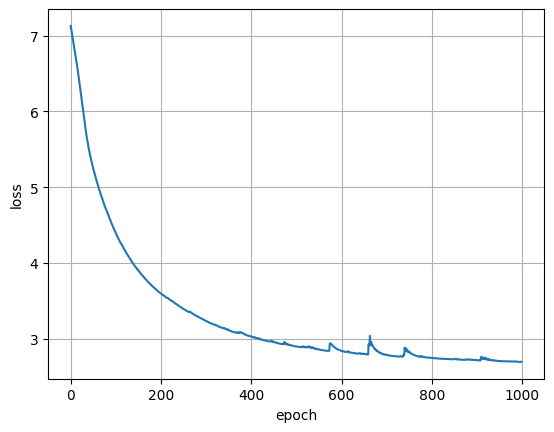

In [12]:
print(f'min loss: {min(losses)}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);

max metric: -1.9272732734680176


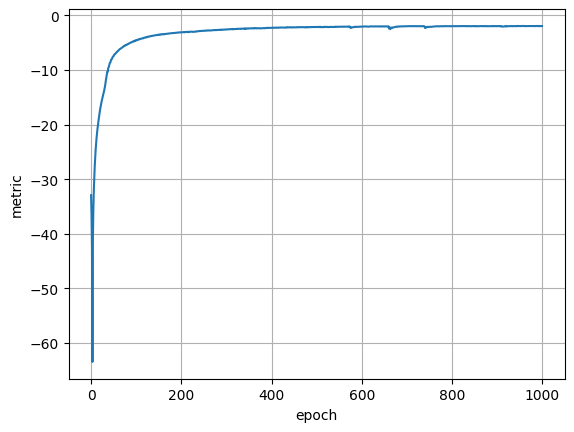

In [13]:
print(f'max metric: {max(metrics)}')

plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);

In [14]:
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

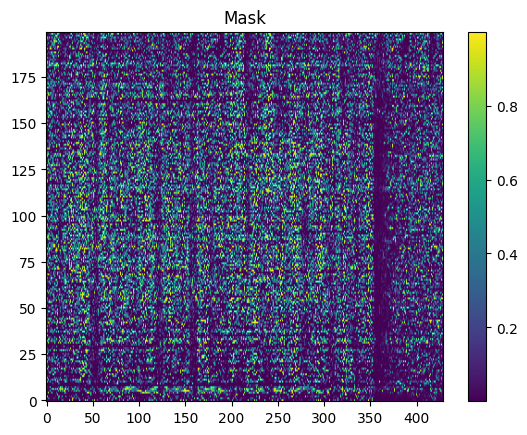

In [15]:
plot_mask(mask.detach()[0][0])

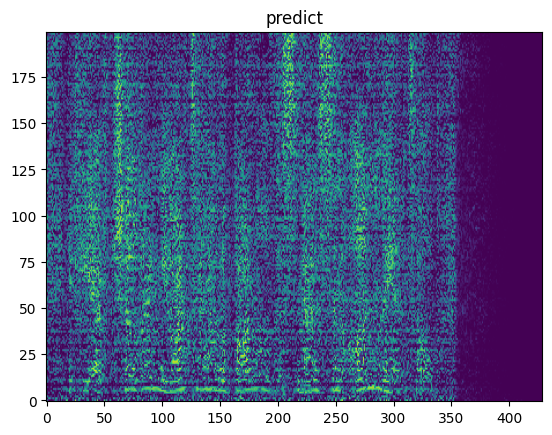

In [16]:
plt.title('predict')
plt.imshow(torch.log(mag_predict+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto");

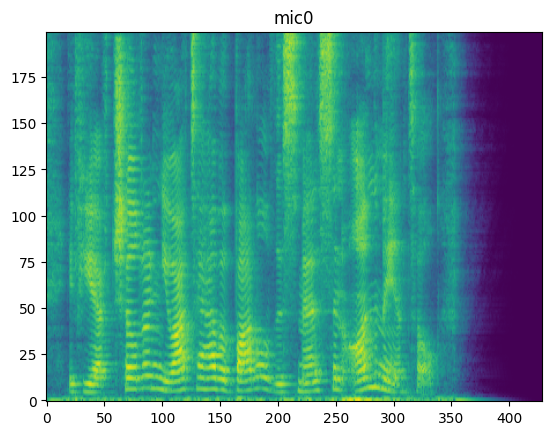

In [17]:
plt.title('mic0')
plt.imshow(torch.log(mag+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

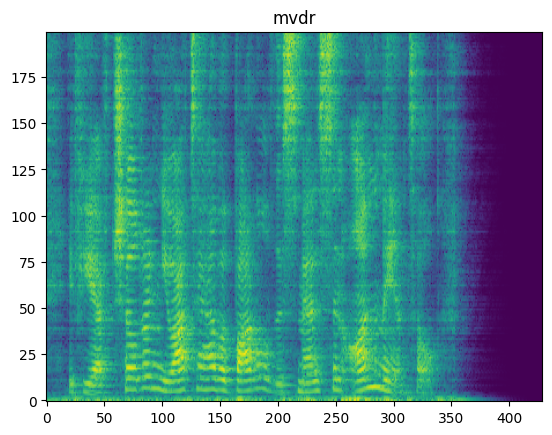

In [18]:
plt.title('mvdr')
plt.imshow(torch.log(mvdr(spec_sample, mask[0]).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

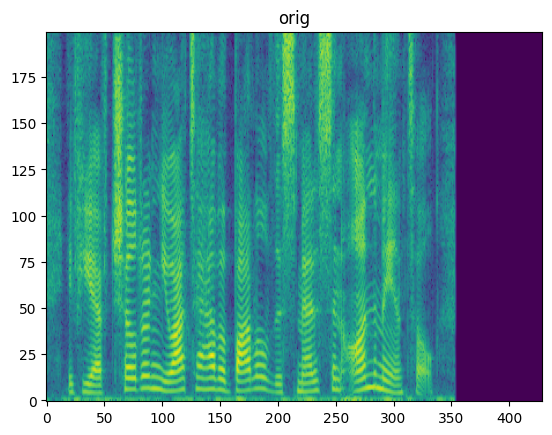

In [19]:
plt.title('orig')
plt.imshow(torch.log(stft.stft(train_target).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");